In [1]:
#%%
import sys
sys.path.append('../')
import JaxSSO.model as Model 
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,ElementParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacfwd,grad,value_and_grad
from scipy.sparse.linalg import spsolve as spsolve_scipy
from scipy.sparse import csr_matrix
from jax.experimental import sparse
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
jax.config.update("jax_enable_x64", True)
from jax.experimental import sparse
print(jax.__version__)
from platform import python_version
jax.config.update('jax_platform_name', 'cpu')
print(python_version())
import scipy
print(scipy.__version__)

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Polygon

0.4.14
3.11.6
1.11.3


# Geometry, some properties

In [2]:
n_col =40
n_row = n_col
x_span = 6
y_span = 6


# Nodal coordinates
xs = np.linspace(0,x_span,n_col+1)
xs = np.tile(xs,n_row+1)
ys = np.linspace(0,y_span,n_row+1)
ys = np.tile(ys,(n_col+1,1))
ys = ys.T.reshape(-1)

zs =  0.02*(-(xs-x_span/2)**2+(x_span/2)**2
          -(ys-x_span/2)**2+(x_span/2)**2)


# Connectivity
n_node = (n_col+1)*(n_row+1)
n_ele = n_col * n_row
cnct = np.zeros((n_ele,4),dtype=int) #Connectivity for MITC4
for i in range(n_ele):
    i_row = i//n_col
    i_col = (i-i_row*n_col)%n_col
    cnct[i,3] = i + i_row*1 + n_col + 1
    cnct[i,2] = cnct[i,3]+1 
    cnct[i,1] = cnct[i,2] - (n_col + 1)
    cnct[i,0] = cnct[i,1] - 1

#Properties, design nodes, load
t = 0.015
E = 2e10
nu = 0.3
design_nodes = []
non_design_nodes = []
loading_nodes = []
for i in range(n_node):
    design_nodes.append(i)
    if [xs[i],ys[i]]!= [x_span/2,0] and [xs[i],ys[i]] != [0,y_span/2] and [xs[i],ys[i]] != [x_span/2,y_span] and [xs[i],ys[i]] != [x_span,y_span/2]:
        #design_nodes.append(i)
        if [xs[i],ys[i]]== [0,0] or [xs[i],ys[i]]== [x_span/2,y_span/2] or [xs[i],ys[i]]== [x_span,0] or [xs[i],ys[i]]== [0,y_span] or [xs[i],ys[i]]== [x_span,y_span]:
            loading_nodes.append(i)
        
    else:
        non_design_nodes.append(i)
design_nodes = np.asarray(design_nodes)
non_design_nodes = np.asarray(non_design_nodes)
Q = 500

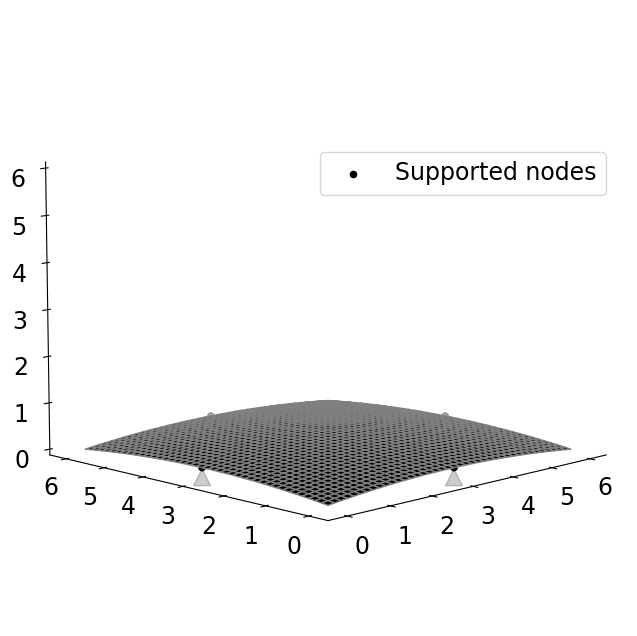

In [3]:
%matplotlib inline




fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,6)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.tick_params(axis='both', which='minor', labelsize=17)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')

all_corners = []


for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(1)
tdco.set_facecolor('black')
tdco.set_edgecolor('grey')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(10, -135)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

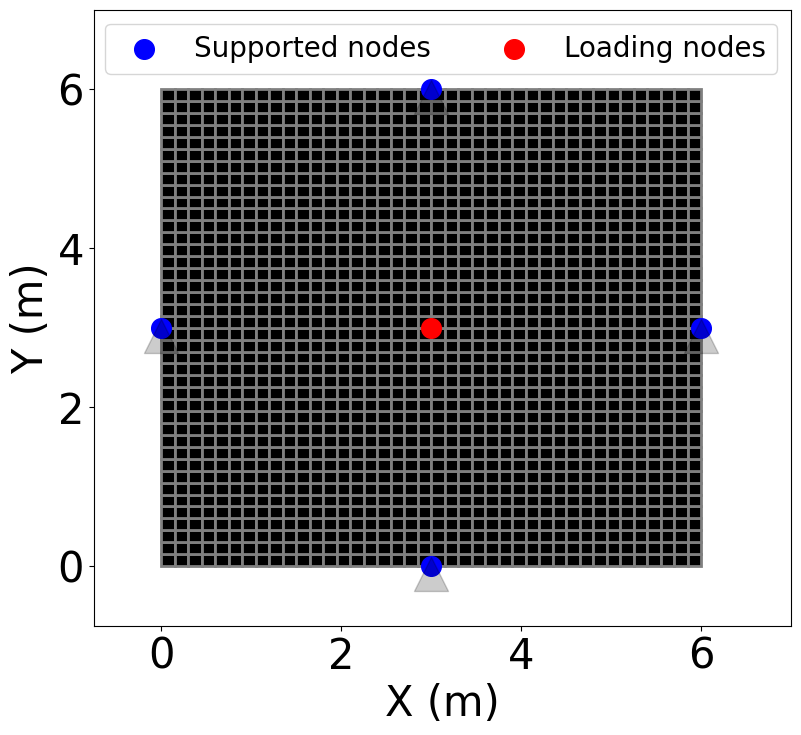

In [4]:
fig,ax = plt.subplots(figsize=(9,8))
ax.set_ylim(-0.75,7)
ax.set_xlim(-0.75,7)
#plt.title('{}-th iteration'.format(i))
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(1)
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('grey')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='blue',s=200,label='Supported nodes')
ax.scatter(xs[int(n_node/2)],ys[int(n_node/2)],color='red',s=200,label='Loading nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes]-0.1,s=600,marker='^',alpha=0.2,color='black')


#cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
#cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20,ncol=2)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

# Define the hat filter

In [5]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))

r = 1.5 #Radius

In [6]:
#Matrix storing XY-projected distance  
dx_ij = xs[:,None]-xs[None,:]
dy_ij = ys[:,None]-ys[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,r)
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(xs.shape[0]).reshape(xs.shape[0],xs.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [7]:
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs_filtered)[design_nodes]

In [8]:
xs_shell = np.average(xs[cnct],axis=1)
ys_shell = np.average(ys[cnct],axis=1)

In [9]:
#Matrix storing XY-projected distance  
dx_ij_shell = xs_shell[:,None]-xs_shell[None,:]
dy_ij_shell = ys_shell[:,None]-ys_shell[None,:]
D_ij_shell = (dx_ij_shell**2 + dy_ij_shell**2)**0.5

#Create the filter mapping matrix
B_ij_ini_shell = Linear_filter(D_ij_shell,0.25)
B_ij_sum_shell = np.sum(B_ij_ini_shell,axis=1)
B_ij_sum_shell = B_ij_sum_shell.repeat(xs_shell.shape[0]).reshape(xs_shell.shape[0],xs_shell.shape[0])
B_ij_shell = B_ij_ini_shell/B_ij_sum_shell

# Some helper functions

In [10]:

def coeff_E(mu):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**7*E

def og_p(p_norm):
    '''
    Return the un-normalized p
    '''
    p_max = 3
    p_min = 0
    return (p_max-p_min)*p_norm+p_min

def norm_p(p):
    p_max = 3
    p_min = 0
    return  (p-p_min)/(p_max-p_min)


def plt_plan(mu_opt_filtered,i=0):
    fig,ax = plt.subplots(figsize=(11,10))
    ax.set_ylim(-2,8)
    ax.set_xlim(-2,8)
    plt.title('{}-th iteration'.format(i),fontsize=15)
    plt.xlabel('X (m)',fontsize=30)
    plt.ylabel('Y (m)',fontsize=30)
    #ax = fig.add_subplot#(projection='3d')
    #ax.set_zlim(0,20)
    #ax.set_xlabel('X (m)',fontsize=15)
    #ax.set_ylabel('Y (m)',fontsize=15)
    #ax.set_zlabel('Z (m)',fontsize=15)
    all_corners= []
    import matplotlib as mpl
    cmap = mpl.colormaps['binary']
    for i in range(n_ele):
        inode = cnct[i,0]
        jnode = cnct[i,1]
        mnode = cnct[i,2]
        nnode = cnct[i,3]
        this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
        alpha = float(mu_opt_filtered[i])
        #cthis_poly.set_alpha(alpha)
        this_poly.set_facecolor(cmap(alpha))
        this_poly.set_edgecolor('black')
        this_poly.set_lw(2)
        ax.add_patch(this_poly)

    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    #Plot a basic wireframe.
    #for i in range(n_ele_bar):
    ##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Supported nodes')
    ax.scatter(xs[non_design_nodes],ys[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')


    cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
    cb.ax.tick_params(labelsize=20)
    plt.legend(fontsize=20)# loc=(0.5,0.7))
    ax.grid(False)
    plt.show()

# Create FE MODEL and SSO_model

In [11]:
#%%
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs_filtered[i])
    if i in non_design_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    if i in loading_nodes:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()




2024-07-24 23:06:30.269029: I external/xla/xla/pjrt/tfrt_cpu_pjrt_client.cc:462] TfrtCpuClient created.
2024-07-24 23:06:30.379861: I external/xla/xla/service/service.cc:168] XLA service 0x558c483301c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-24 23:06:30.379881: I external/xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-07-24 23:06:30.380089: I external/xla/xla/pjrt/gpu/se_gpu_pjrt_client.cc:633] Using BFC allocator.
2024-07-24 23:06:30.380115: I external/xla/xla/pjrt/gpu/gpu_helpers.cc:105] XLA backend allocating 63969804288 bytes on device 0 for BFCAllocator.


In [12]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model


#Nodal parameter: for shape optimization
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Element parameter: 
for eletag in range(n_ele):
    eleparameter = ElementParameter(eletag,ele_type = 1,prop_type = 1) # element object, quad's young's modulus
    sso_model.add_eleparameter(eleparameter)


#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

# Define the objective function

In [13]:
C_hist = []
mu_sum_list =[]
def objective_filter(x,sso_model=sso_model):
    '''
    Design parameters:
    node params: normalized control point (pre filtered)
    ele params: pre-filtered mu
    '''
    node_params = x[:sso_model.nodeparameters_values.shape[0]]
    ele_params = x[sso_model.nodeparameters_values.shape[0]:]
    
    #Normalized pt - Unnormalized Control pt - filtered actual geometry pt
    p = zs.copy()
    p[design_nodes]= og_p(node_params) #Unnormalized Control pt
    z = (B_ij@p)[design_nodes] #filtered actual geometry pt
    sso_model.update_nodeparameter(z) # Update the model
    
    #pre-filtered mu
    filtered_mu = B_ij_shell@ele_params
    E_step = coeff_E(filtered_mu) #Penalized Young's modulus
    sso_model.update_eleparameter(E_step) # Update the model
    
    #JAX-SSO
    C,sens = sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)
    C_hist.append(C)
    print("{}th iteration, C = {} ".format(len(C_hist),C))
    mu_sum_list.append(np.sum(ele_params))
    
    #Chain rule for final gradient
    sens_node = sens[:sso_model.nodeparameters_values.shape[0]]
    sens_shape = np.asarray((sens_node@B_ij[design_nodes])[design_nodes],dtype=float)
    sens_shape_norm = (sens_shape@jacfwd(og_p)(x[:sso_model.nodeparameters_values.shape[0]]))
    
    sens_ele =sens[sso_model.nodeparameters_values.shape[0]:]
    sens_topo = sens_ele@jacfwd(coeff_E)(B_ij_shell@x[sso_model.nodeparameters_values.shape[0]:])
    sens_topo_final = sens_topo@B_ij_shell
    
    
    
    if len(C_hist)%5==0:
        i = len(C_hist)
        print(jnp.sum(ele_params))
        plt_plan(filtered_mu,i)
    return float(C), jnp.hstack((sens_shape_norm,sens_topo_final))

In [14]:
x_ini = jnp.hstack((0.5*jnp.abs(norm_p(sso_model.nodeparameters_values)),0.1*np.ones(sso_model.eleparameters_values.shape[0])))#initial parameters

# Implementing MMA to optimize

In [15]:
import nlopt

In [16]:
#Nlopt objective and constraints
def f(x,grad):
    res_1,res_2 = objective_filter(x)
    if grad.size>0:
        grad[:] = res_2

    return res_1

#Constraints on volume minimization
def vol(x):
    '''
    Return the volume constraints
    '''
    mu = x[sso_model.nodeparameters_values.shape[0]:] #the density
    return jnp.sum(mu)-0.5*sso_model.eleparameters_values.shape[0]
def fc(x,grad):
    res_1,res_2 = value_and_grad(vol)(x) 
    if grad.size>0:
        grad[:] = res_2

    return float(res_1)

1th iteration, C = 2069037049.3141956 
2th iteration, C = 17332218180.469406 
3th iteration, C = 17332164098.373833 
4th iteration, C = 17331623266.78144 
5th iteration, C = 17322707349.682503 
402.2641365940383


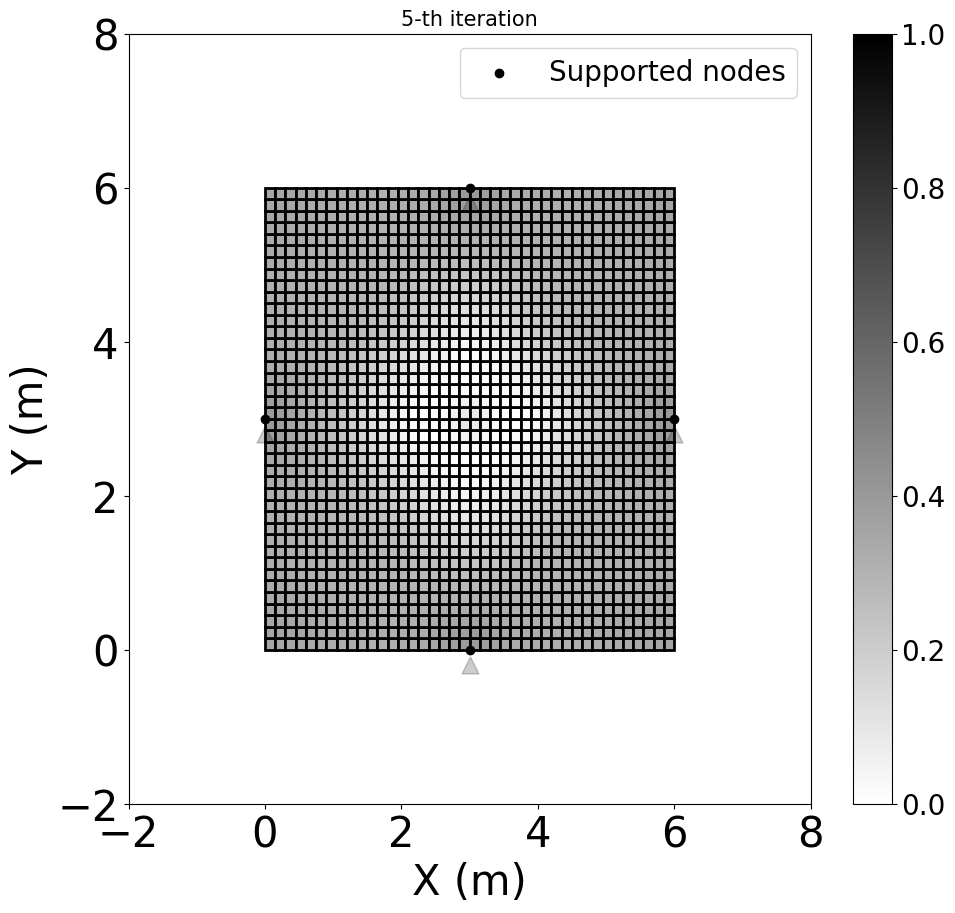

6th iteration, C = 17237320431.492477 
7th iteration, C = 16410922180.701101 
8th iteration, C = 7855242361.111804 
9th iteration, C = 8880790.954036962 
10th iteration, C = 634051.8246669689 
418.0867743556802


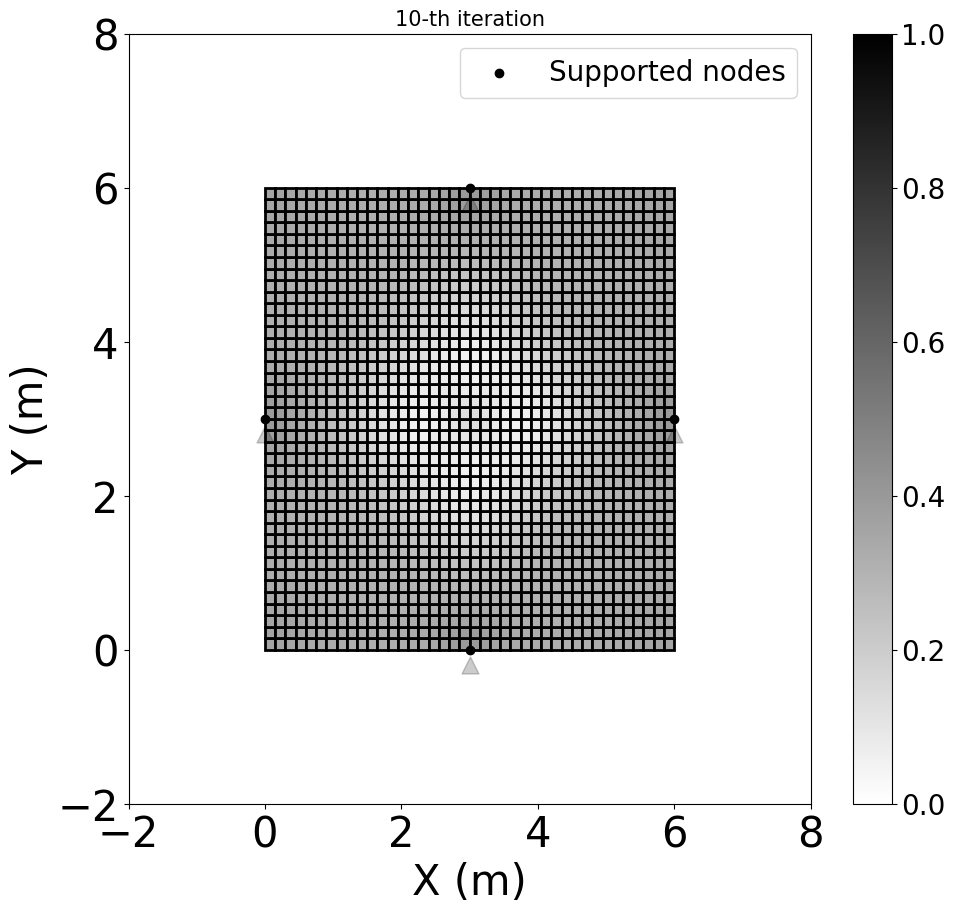

11th iteration, C = 619845.3925683516 
12th iteration, C = 510622.5897864964 
13th iteration, C = 280859.99139787245 
14th iteration, C = 256736.4782687853 
15th iteration, C = 120288.71930176145 
437.3325198677028


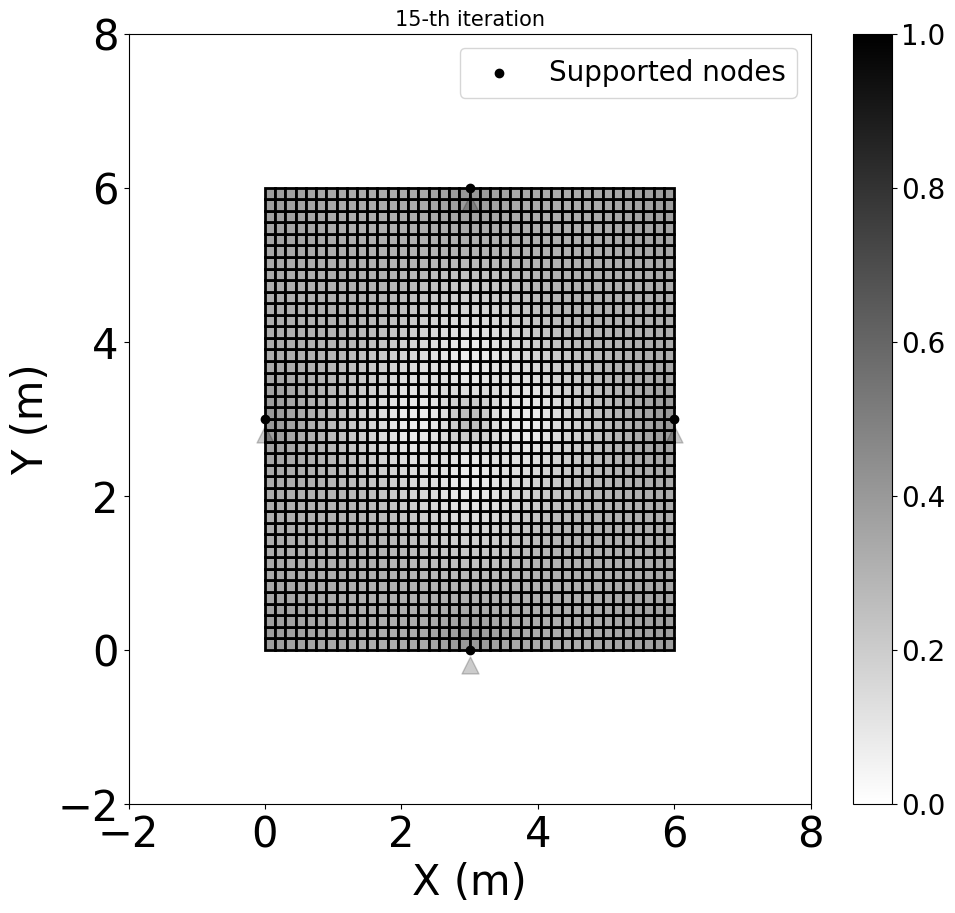

16th iteration, C = 4537.754344589248 
17th iteration, C = 4238.929061864168 
18th iteration, C = 1977.3681883042473 
19th iteration, C = 187.73294383948536 
20th iteration, C = 169.01186379033803 
643.7762530984851


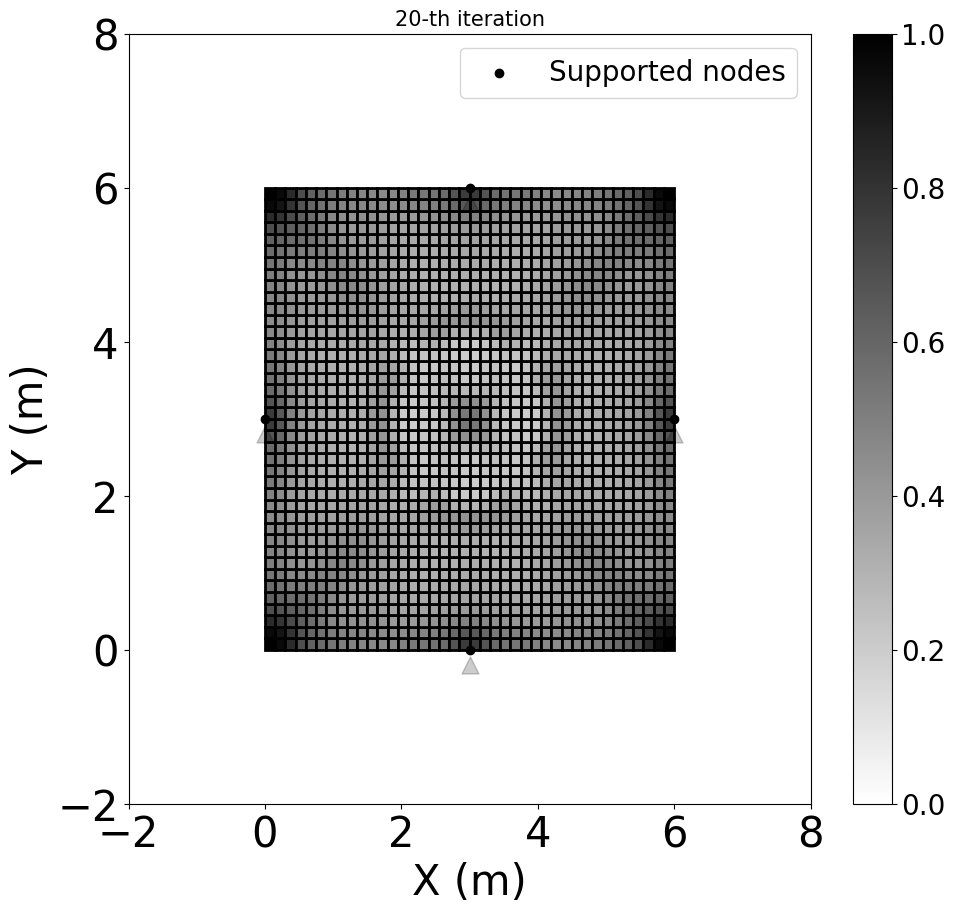

21th iteration, C = 69.2896288384477 
22th iteration, C = 20.912841551478216 
23th iteration, C = 15.435112612432853 
24th iteration, C = 15.748247243703302 
25th iteration, C = 12.50962306195691 
799.3674547904119


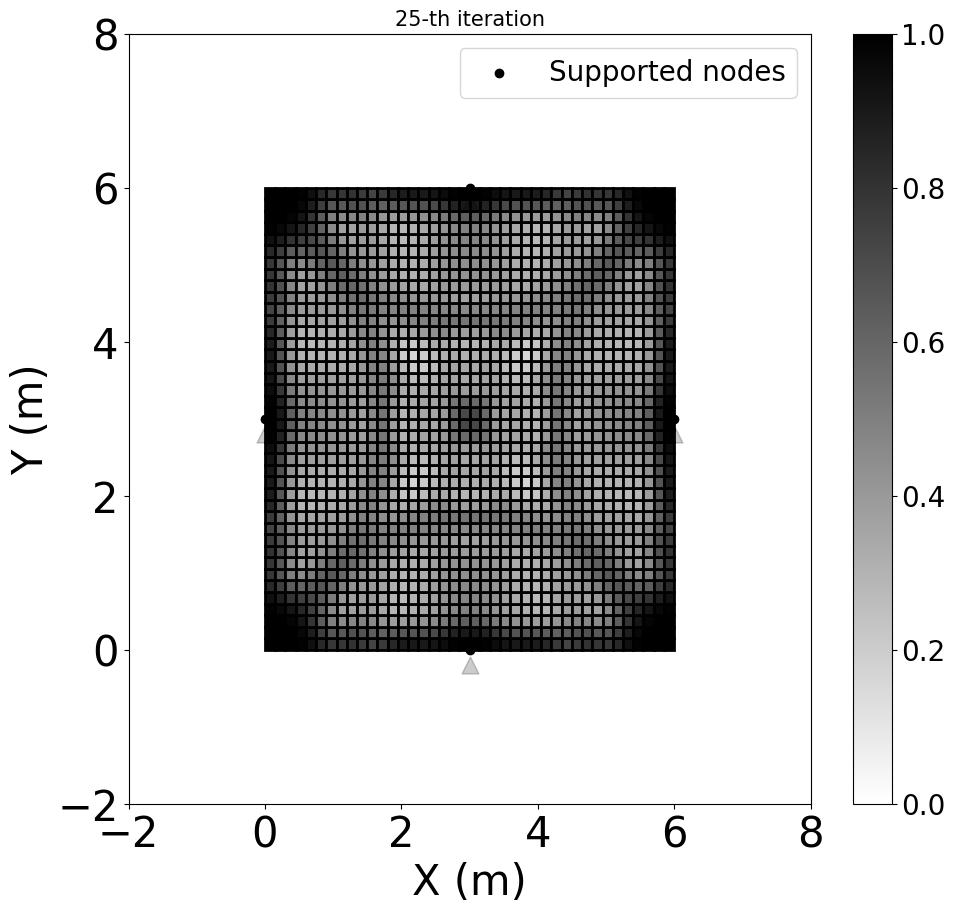

26th iteration, C = 10.848994163222875 
27th iteration, C = 10.020927492835385 
28th iteration, C = 6.846302269461097 
29th iteration, C = 3.942352756727743 
30th iteration, C = 14.599016921921638 
790.1777543378385


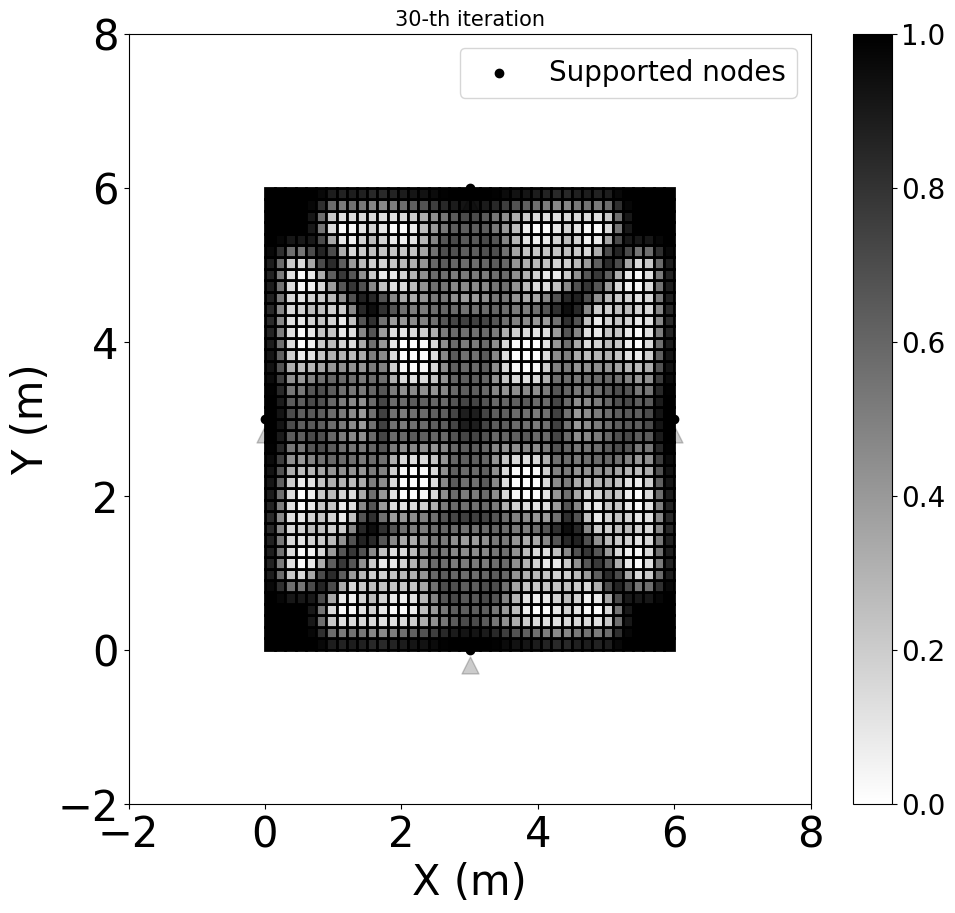

31th iteration, C = 3.49582097523793 
32th iteration, C = 3.3656008891672355 
33th iteration, C = 3.285213370793164 
34th iteration, C = 2.8856581467969953 
35th iteration, C = 11.326235261250941 
787.1241629779436


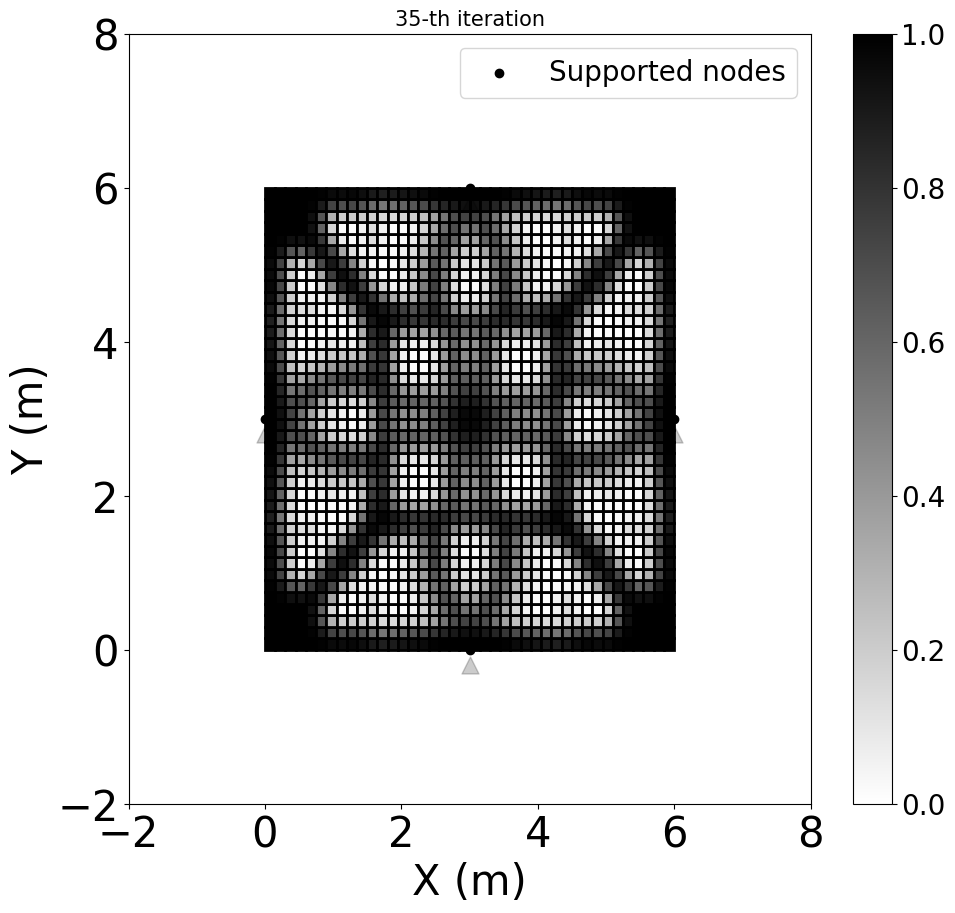

36th iteration, C = 4.819096585386352 
37th iteration, C = 2.8070702959870464 
38th iteration, C = 2.7479898978236537 
39th iteration, C = 2.7140121527843197 
40th iteration, C = 2.504913841768711 
798.9735156224123


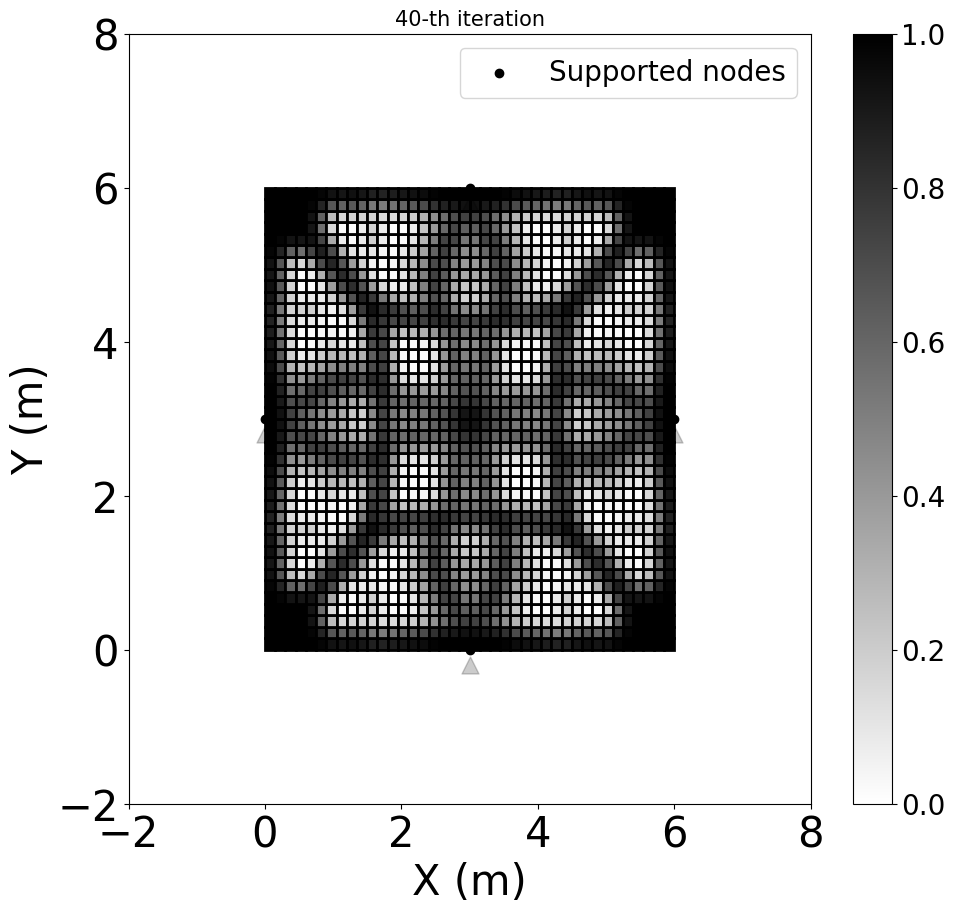

41th iteration, C = 6.825792177336346 
42th iteration, C = 2.700575352894363 
43th iteration, C = 2.4526053497744087 
44th iteration, C = 2.4140070659813397 
45th iteration, C = 2.9044140446610607 
797.5389934311729


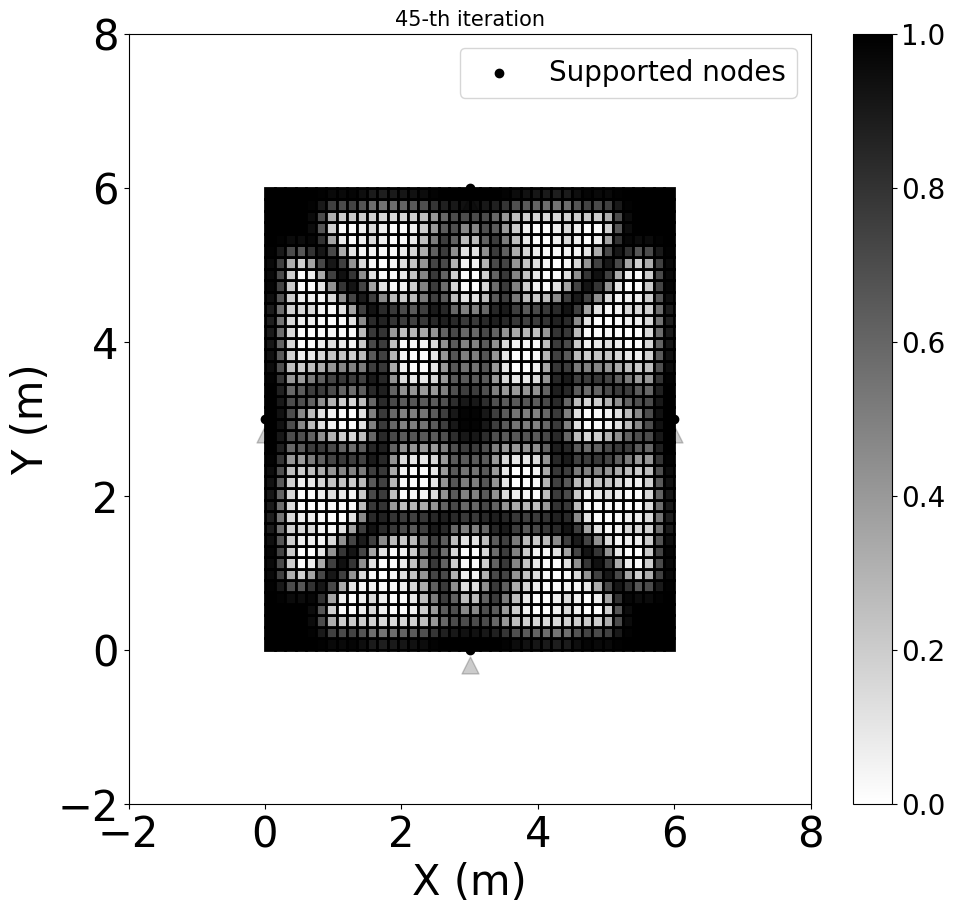

46th iteration, C = 2.3654204116380826 
47th iteration, C = 2.3637995943441217 
48th iteration, C = 2.307456664975359 
49th iteration, C = 2.2878549155685985 
50th iteration, C = 2.1930428027272364 
799.5046548173772


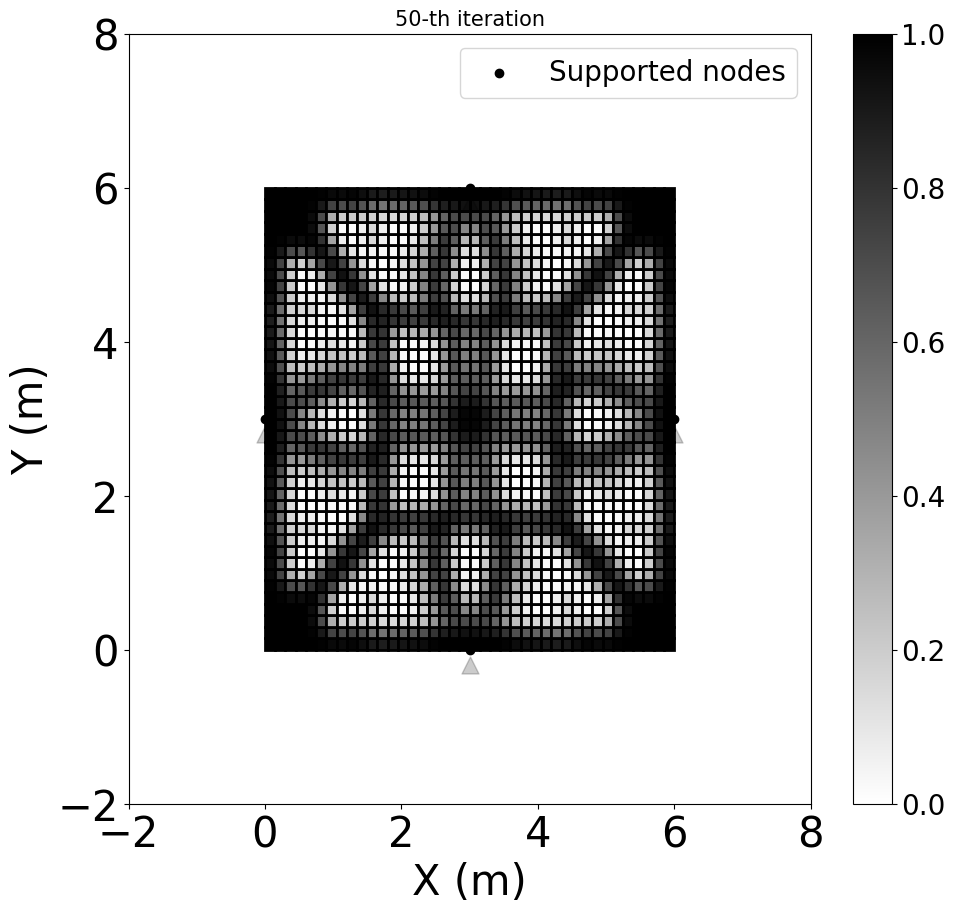

51th iteration, C = 2.040597663817957 
52th iteration, C = 5.928887303399564 
53th iteration, C = 2.1921933018481563 
54th iteration, C = 1.9628683830737923 
55th iteration, C = 2.019365242205474 
799.7044142027698


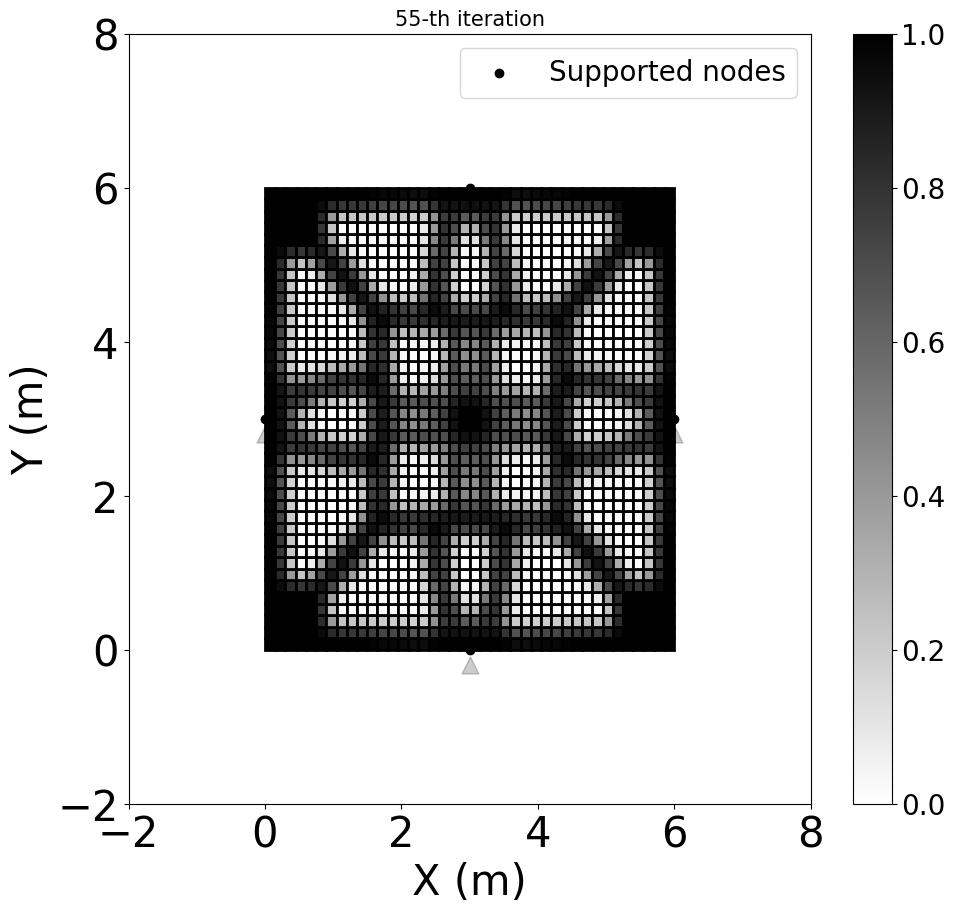

56th iteration, C = 1.927620303784936 
57th iteration, C = 3.3668409434064333 
58th iteration, C = 1.9311916198015489 
59th iteration, C = 1.9161860797177108 
60th iteration, C = 1.891870060495868 
799.773330258604


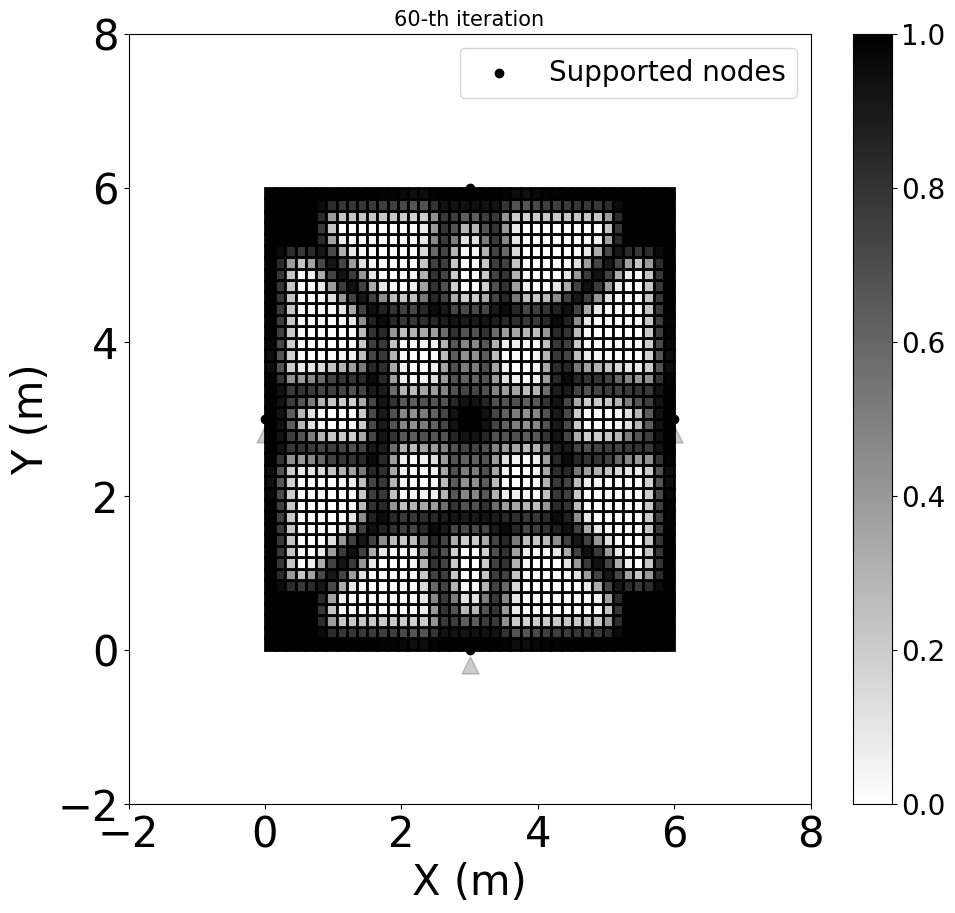

61th iteration, C = 2.40136858736613 
62th iteration, C = 1.8917189940225672 
63th iteration, C = 1.9733134754330806 
64th iteration, C = 1.8786012460671875 
65th iteration, C = 1.877746223795434 
799.9148773776196


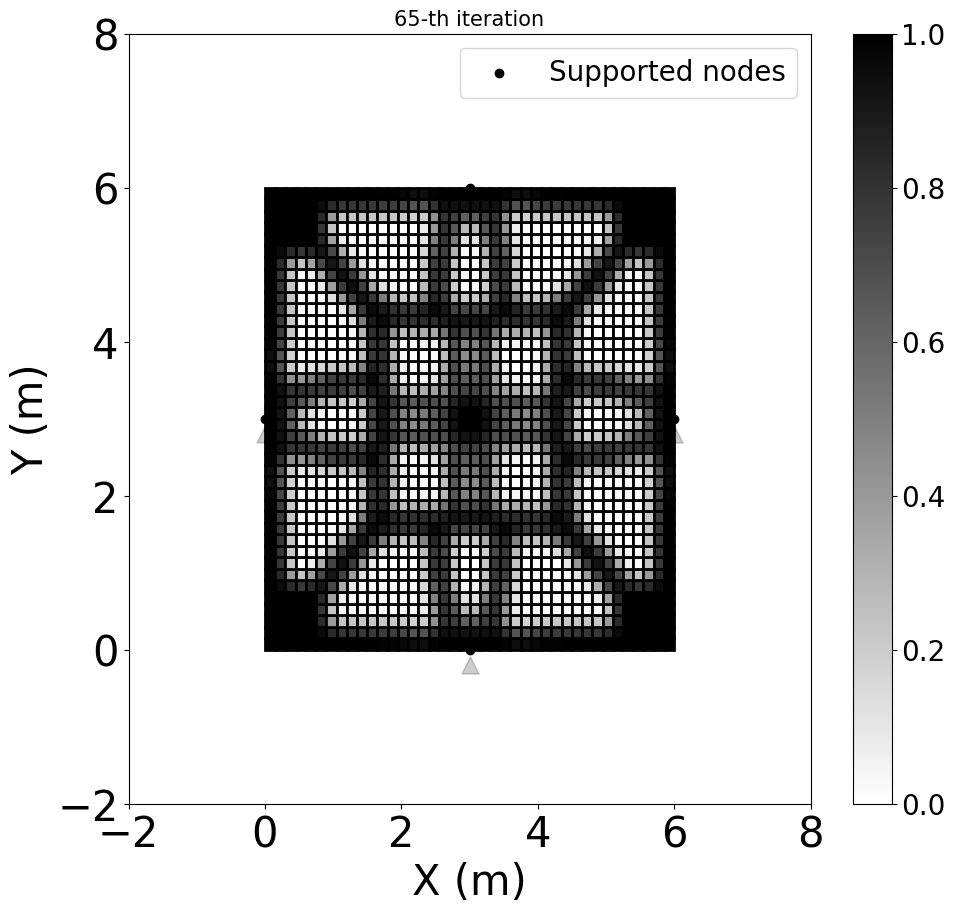

66th iteration, C = 1.9268428871150596 
67th iteration, C = 1.861245757999377 
68th iteration, C = 1.85845949566506 
69th iteration, C = 1.848743995981507 
70th iteration, C = 5.32650407270523 
799.3373333863501


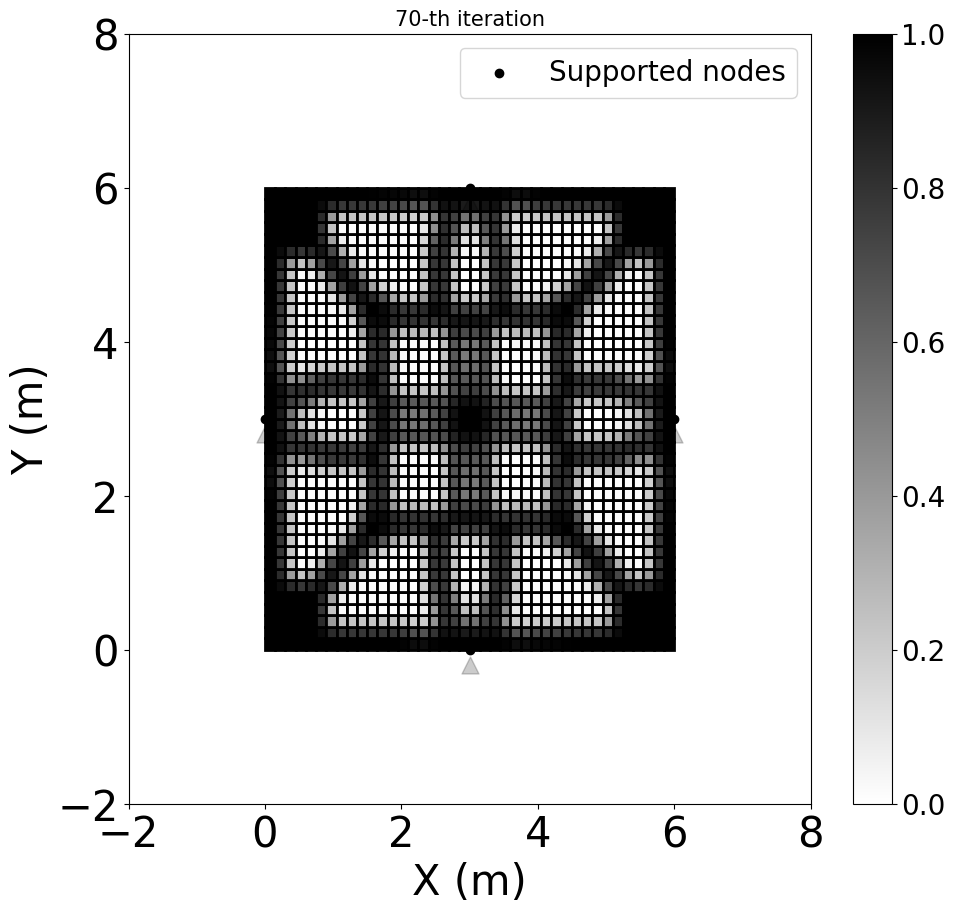

71th iteration, C = 1.9134179242827916 
72th iteration, C = 1.8414307536456984 
73th iteration, C = 1.8631380912697728 
74th iteration, C = 1.834227384988269 
75th iteration, C = 1.8425327426537423 
799.9696397138123


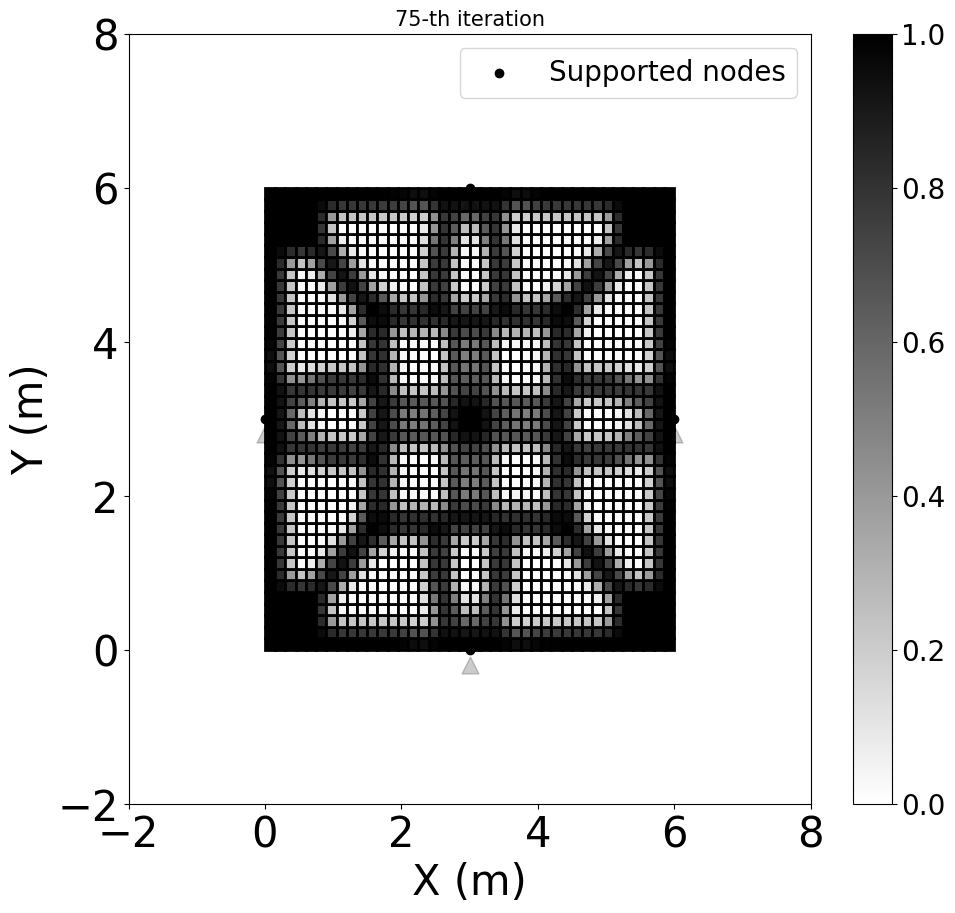

76th iteration, C = 1.8281926944020304 
77th iteration, C = 1.8123306807863118 
78th iteration, C = 6.04545763778143 
79th iteration, C = 2.084687528647463 
80th iteration, C = 1.805966476393996 
799.997363254772


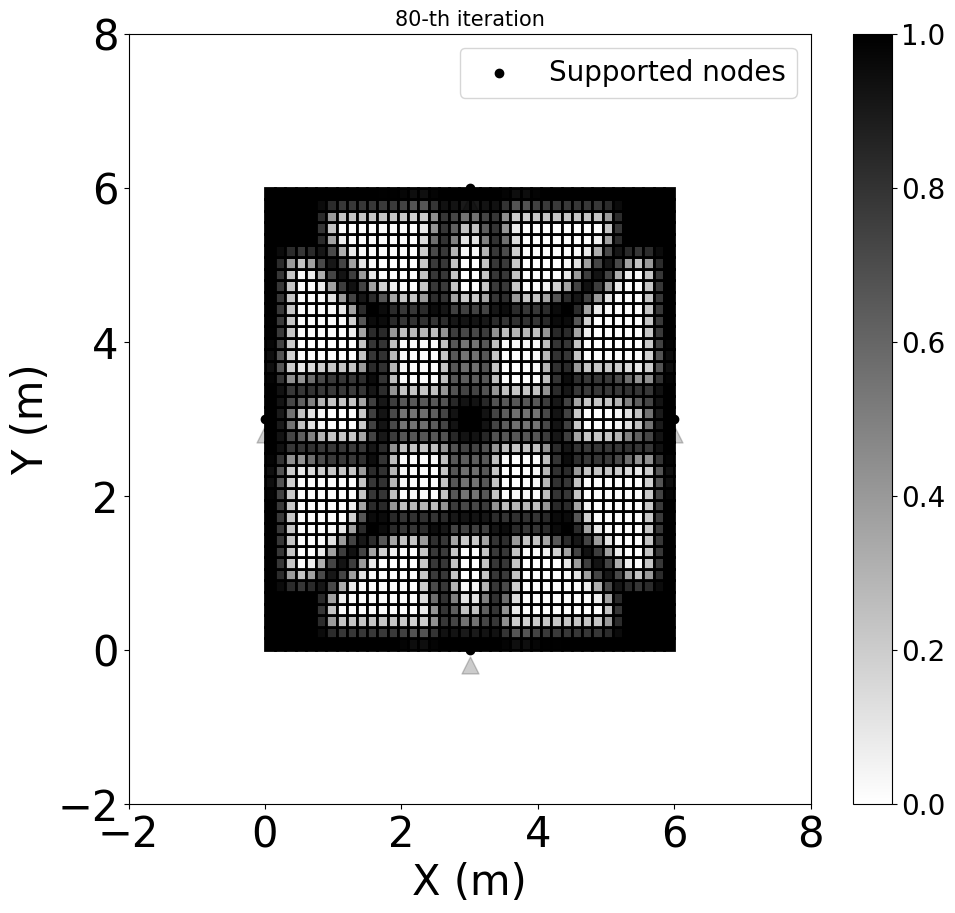

81th iteration, C = 1.8033639408022348 
82th iteration, C = 1.7921186329241714 
83th iteration, C = 1.9938878565220348 
84th iteration, C = 1.7846478796568506 
85th iteration, C = 1.782831301192717 
799.9994046111879


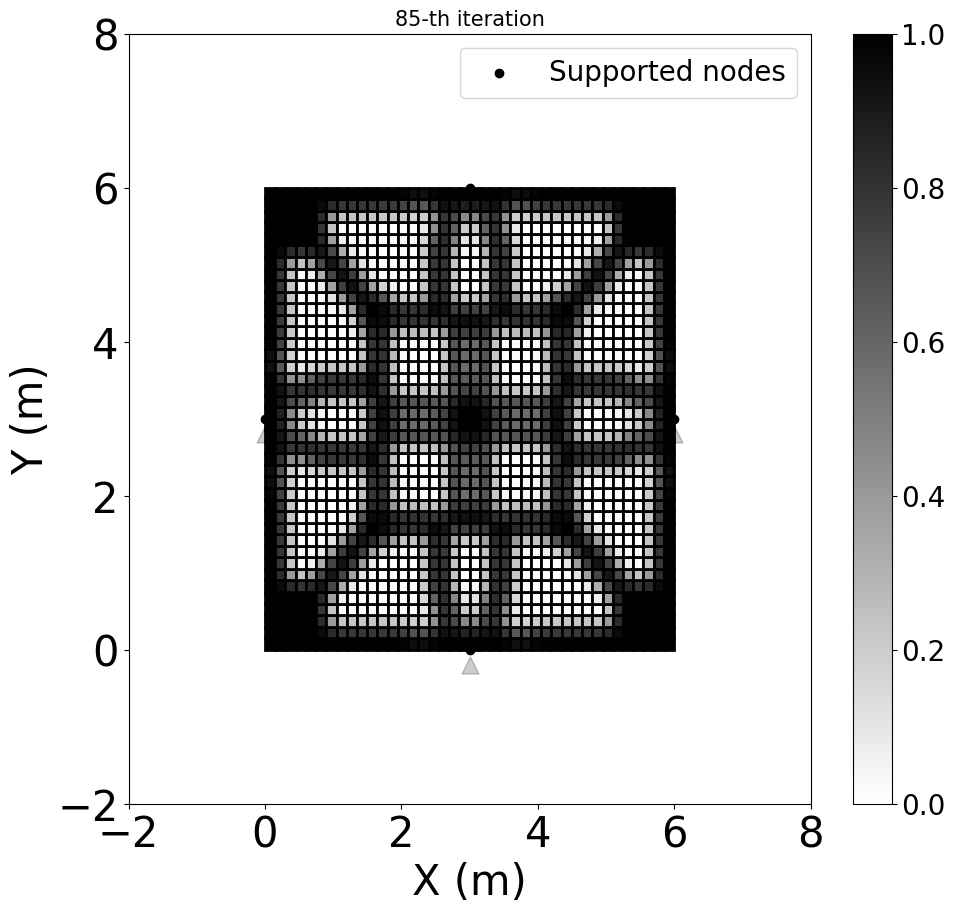

86th iteration, C = 1.7735747369097354 
87th iteration, C = 2.4334889713349805 
88th iteration, C = 1.7918998964601491 
89th iteration, C = 1.7710558056990813 
90th iteration, C = 1.7689714433824468 
799.9975641902561


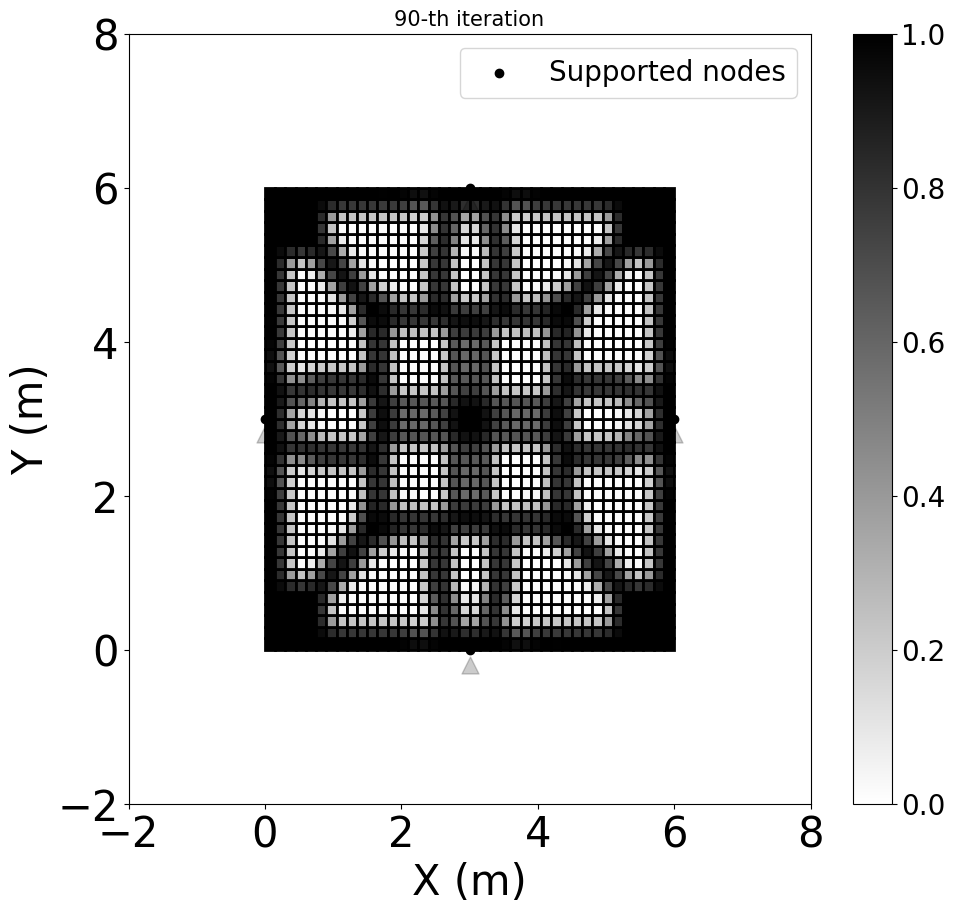

91th iteration, C = 1.7913880503055408 
92th iteration, C = 1.76640323099348 
93th iteration, C = 1.769595948727406 
94th iteration, C = 1.7639498259586184 
95th iteration, C = 1.755395858484129 
799.9675533898862


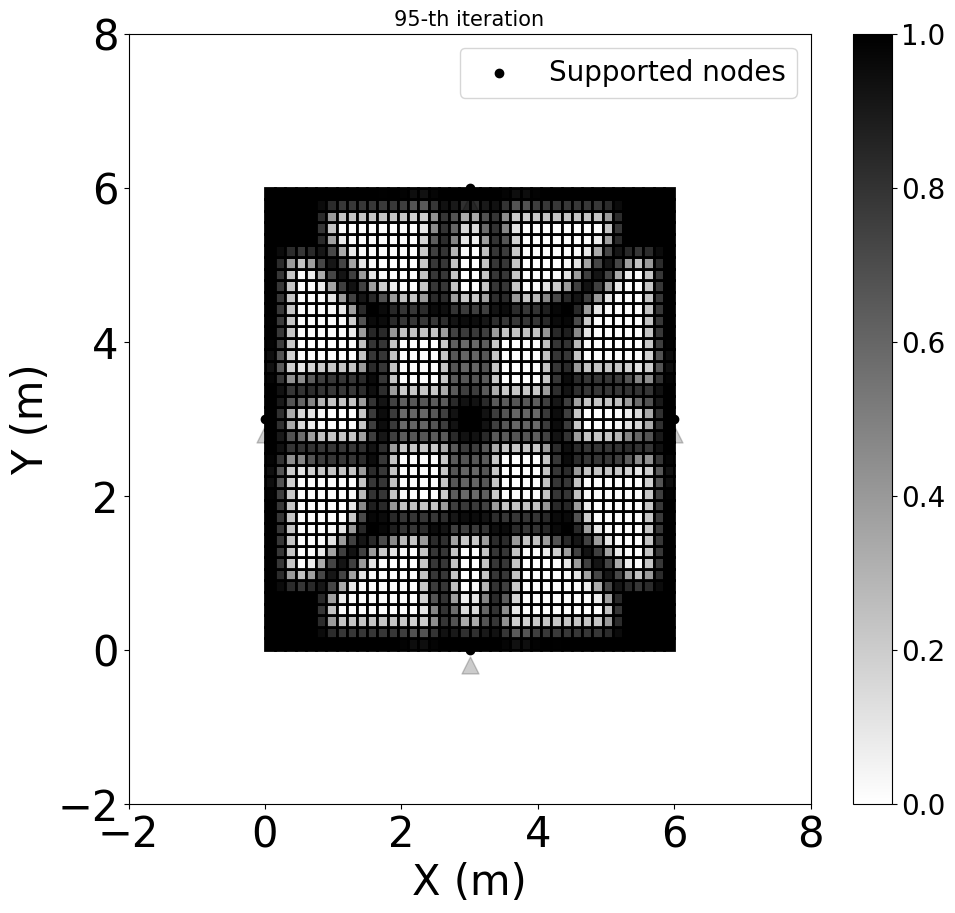

96th iteration, C = 4.905085642915982 
97th iteration, C = 2.077096726278486 
98th iteration, C = 1.753262131083817 
99th iteration, C = 1.7512355929323409 
100th iteration, C = 1.743252386792447 
799.981654914203


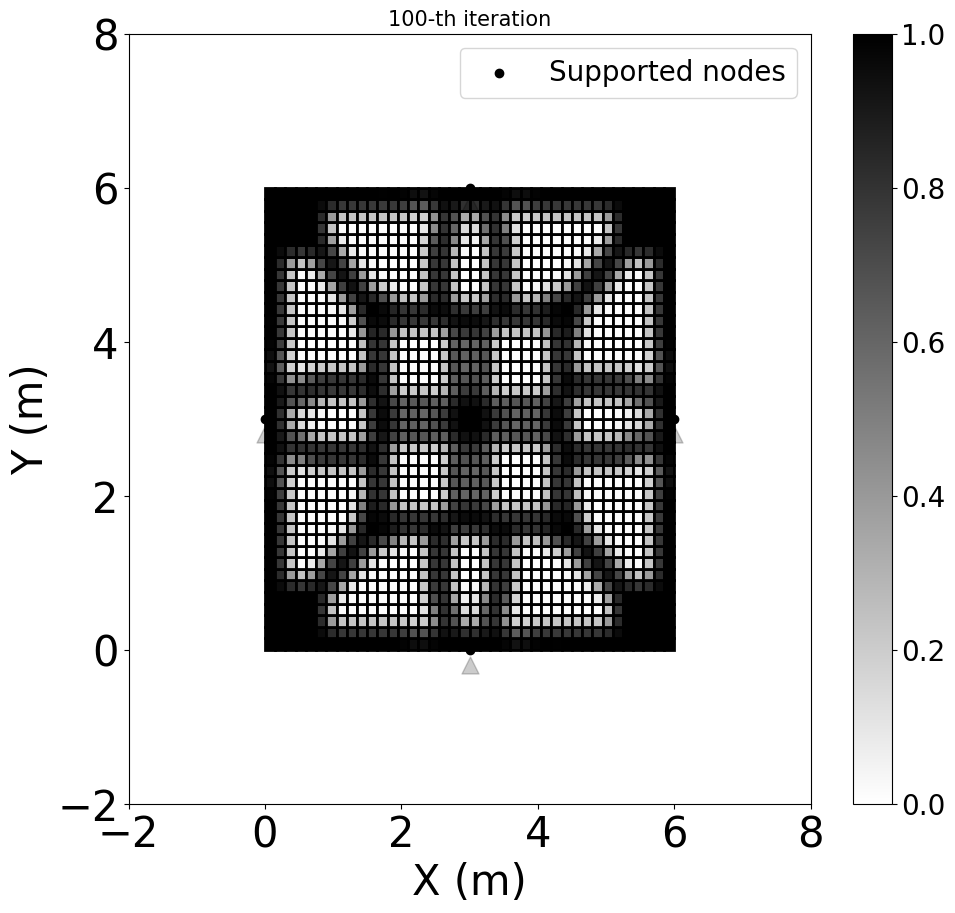

101th iteration, C = 3.3230068783781674 
102th iteration, C = 1.8228089949857846 
103th iteration, C = 1.740363955374807 
104th iteration, C = 1.7275176536154453 
105th iteration, C = 3.236502955994549 
799.1169606409119


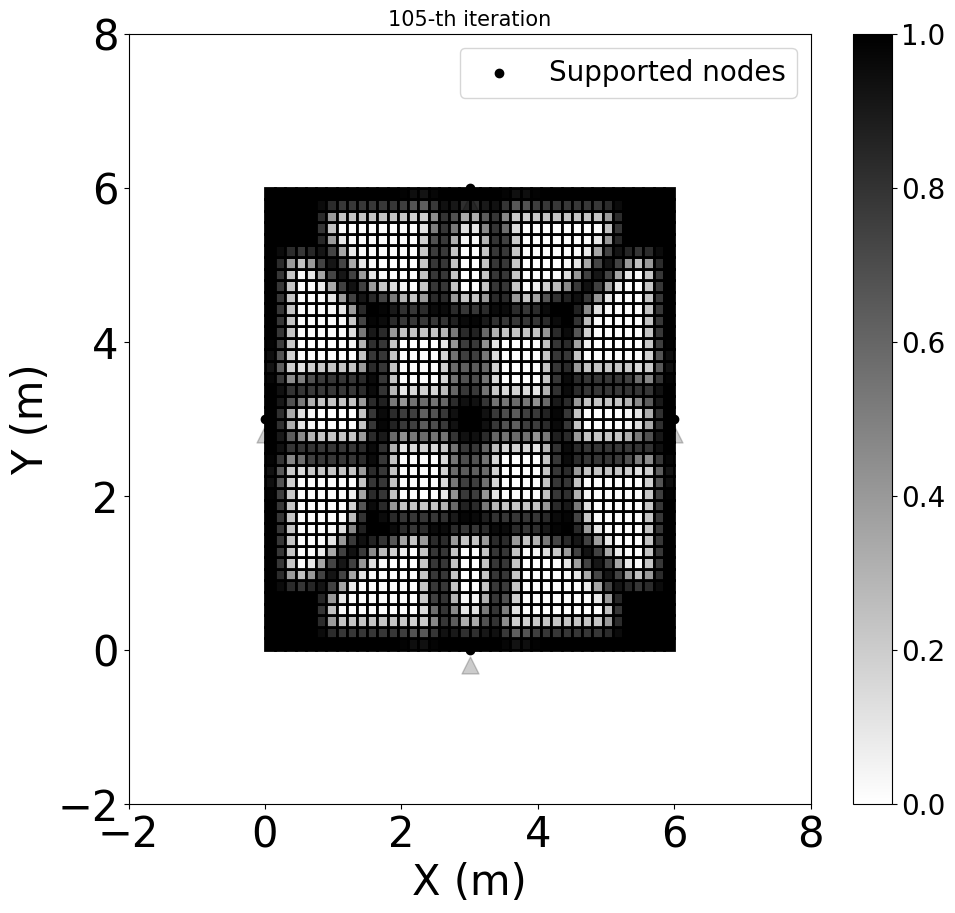

106th iteration, C = 1.8102216067021222 
107th iteration, C = 1.7217023322606215 
108th iteration, C = 1.7144152096329885 
109th iteration, C = 2.0460900085058933 
110th iteration, C = 1.7026240998925435 
799.99821949357


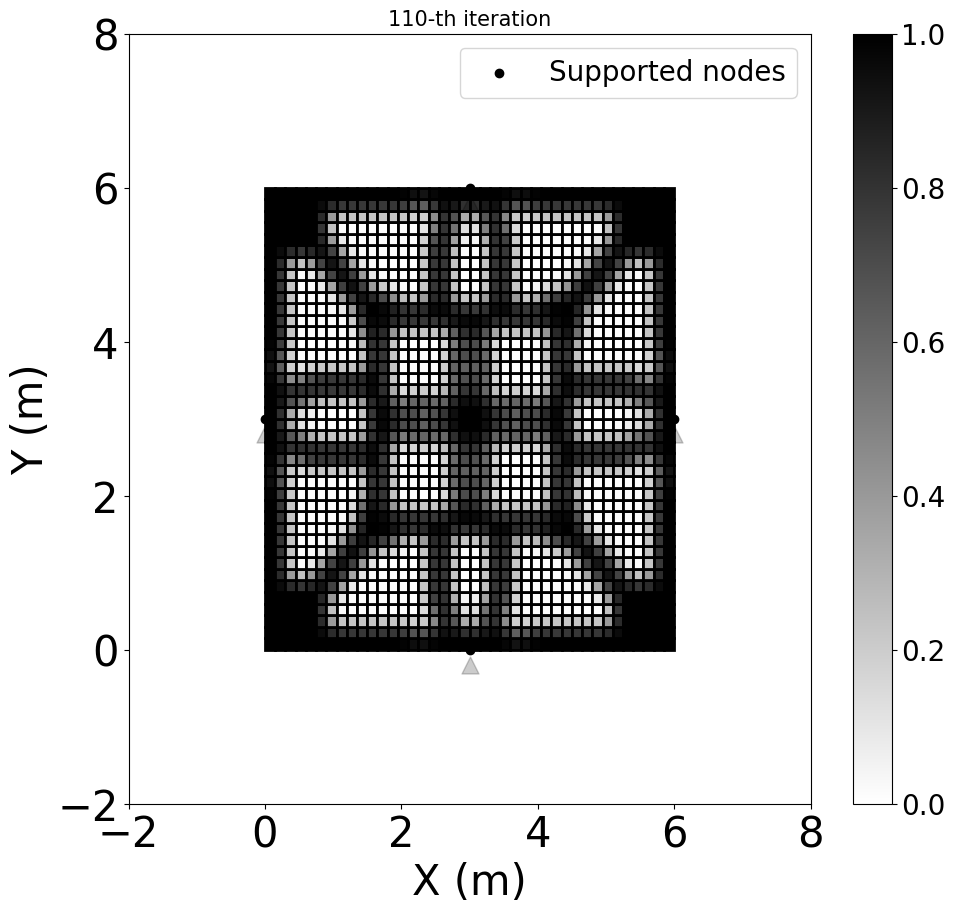

111th iteration, C = 1.7009095082212817 
112th iteration, C = 1.6929375368791433 
113th iteration, C = 2.345920201439026 
114th iteration, C = 1.71264840229848 
115th iteration, C = 1.6900404894044543 
799.993387728396


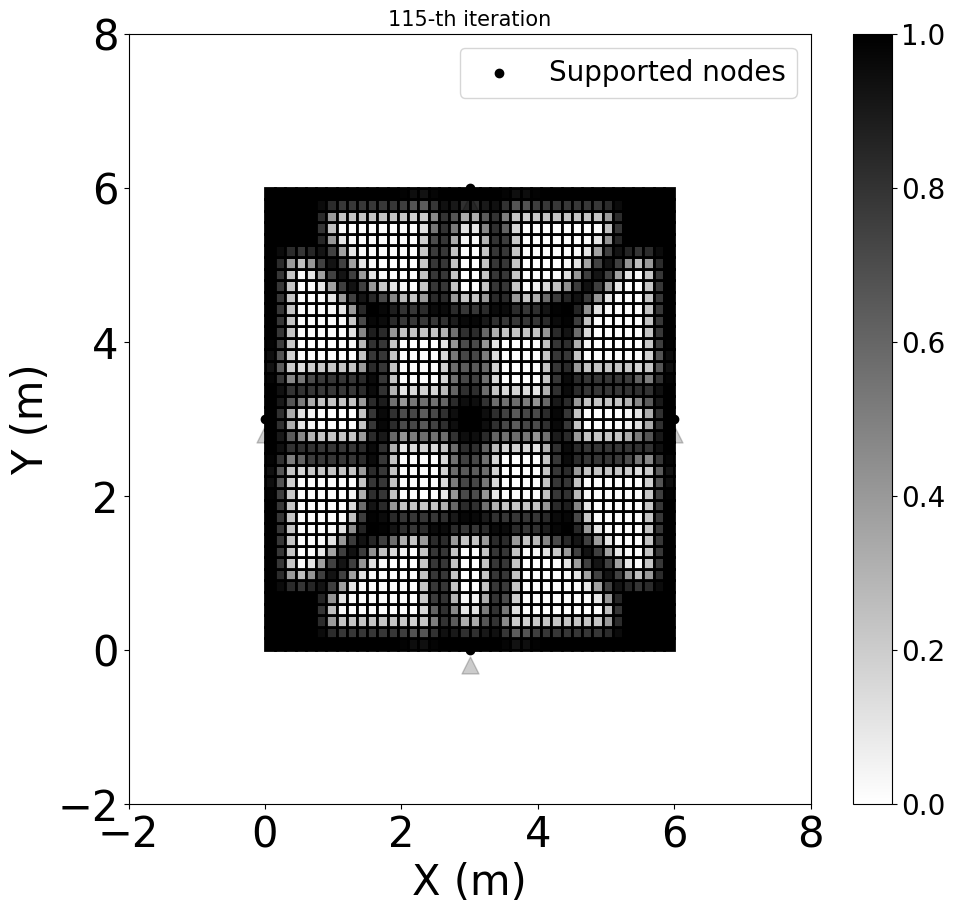

116th iteration, C = 1.6874594505367664 
117th iteration, C = 1.676127909167822 
118th iteration, C = 3.5207682578043684 
119th iteration, C = 1.8674315540816273 
120th iteration, C = 1.6729123100137635 
799.9962052520186


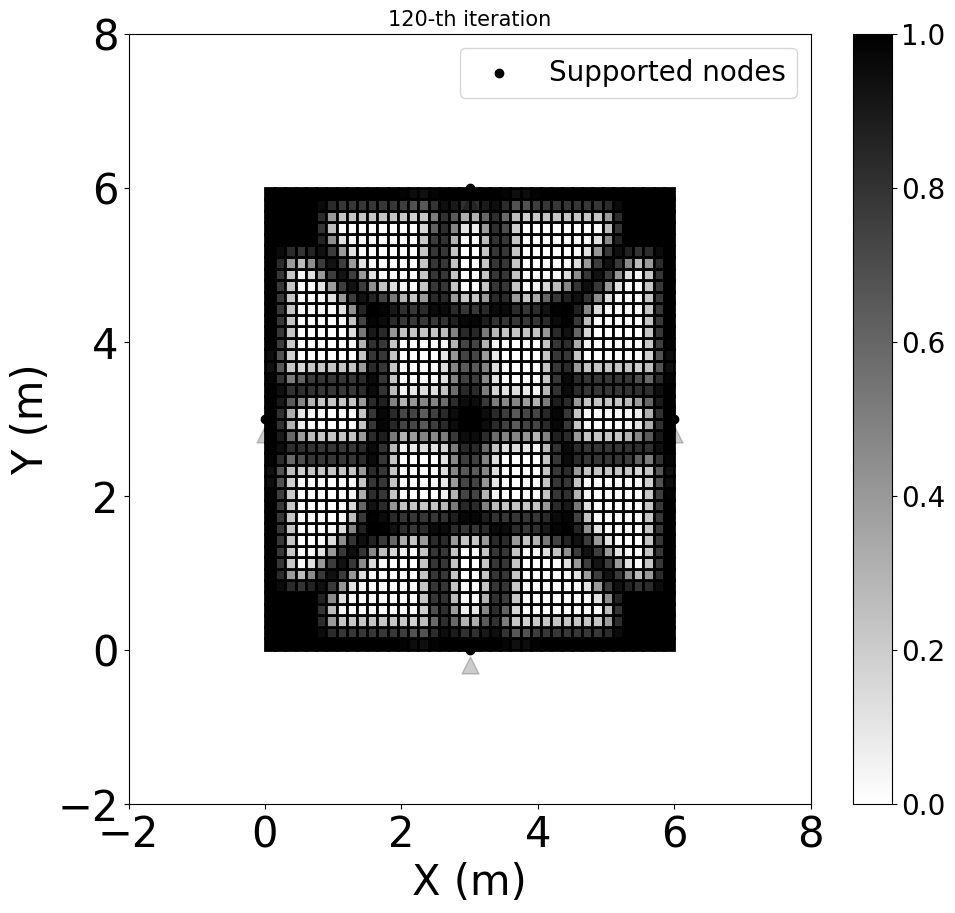

121th iteration, C = 1.671235588673674 
122th iteration, C = 1.6640034636624008 
123th iteration, C = 4.7753979022488355 
124th iteration, C = 1.8879594813903662 
125th iteration, C = 1.6605185151151762 
799.9966583106317


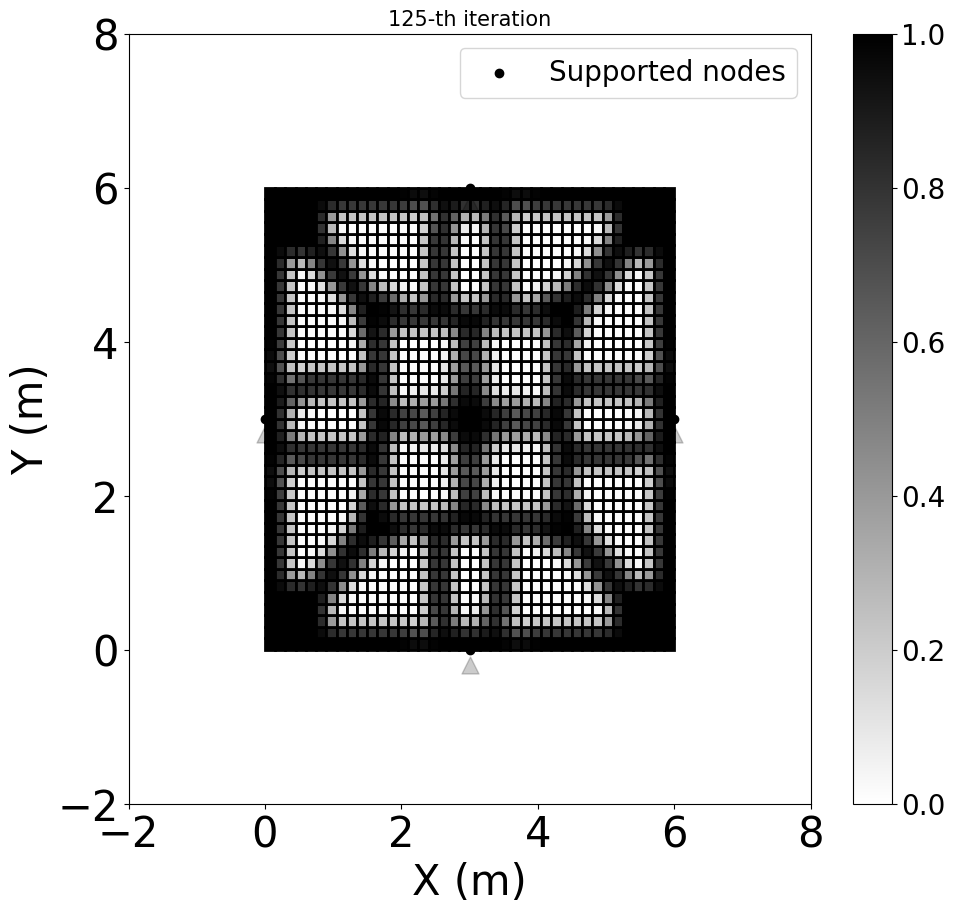

126th iteration, C = 1.6577356125185496 
127th iteration, C = 1.6505791263243415 
128th iteration, C = 2.260074634156803 
129th iteration, C = 1.665020989938651 
130th iteration, C = 1.6484604975416763 
799.9955716016837


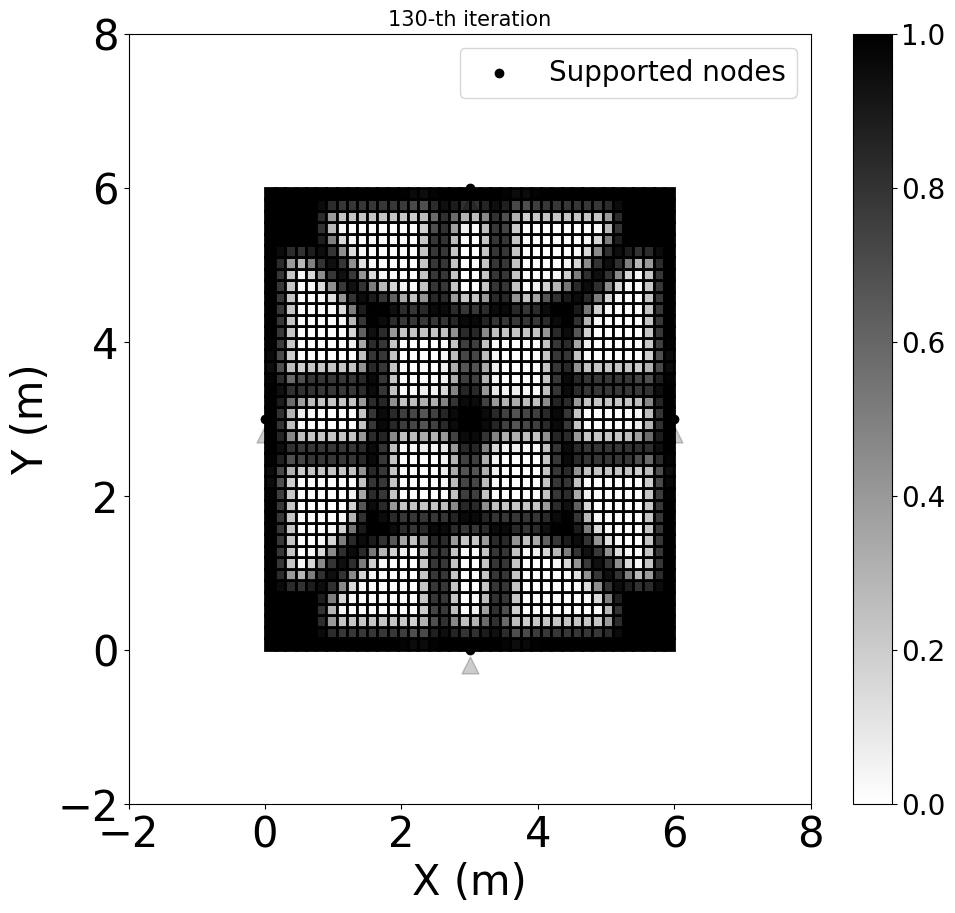

131th iteration, C = 1.6428778095877548 
132th iteration, C = 1.8819119853614372 
133th iteration, C = 1.6388894181269136 
134th iteration, C = 1.6374058833404885 
135th iteration, C = 1.634266543415523 
799.9568462145827


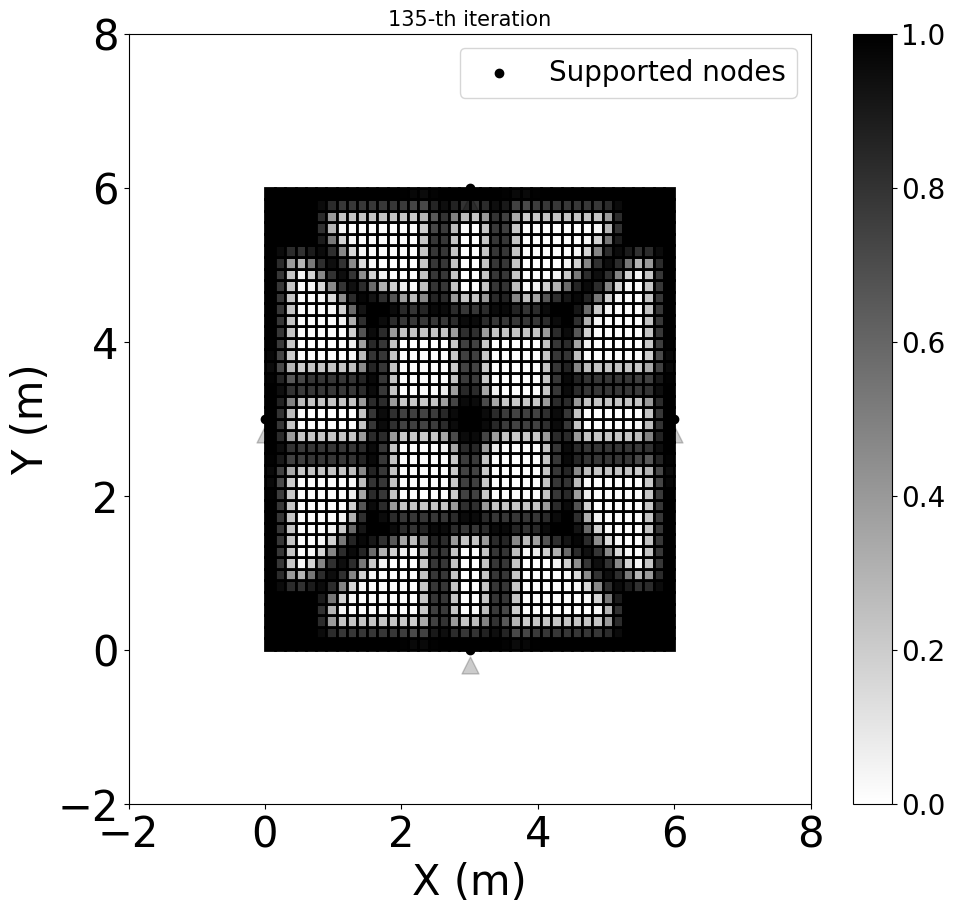

136th iteration, C = 1.6485965911604772 
137th iteration, C = 1.6326287857230564 
138th iteration, C = 1.630550591689621 
139th iteration, C = 2.6911964978602896 
140th iteration, C = 1.641466561434864 
799.9881052416108


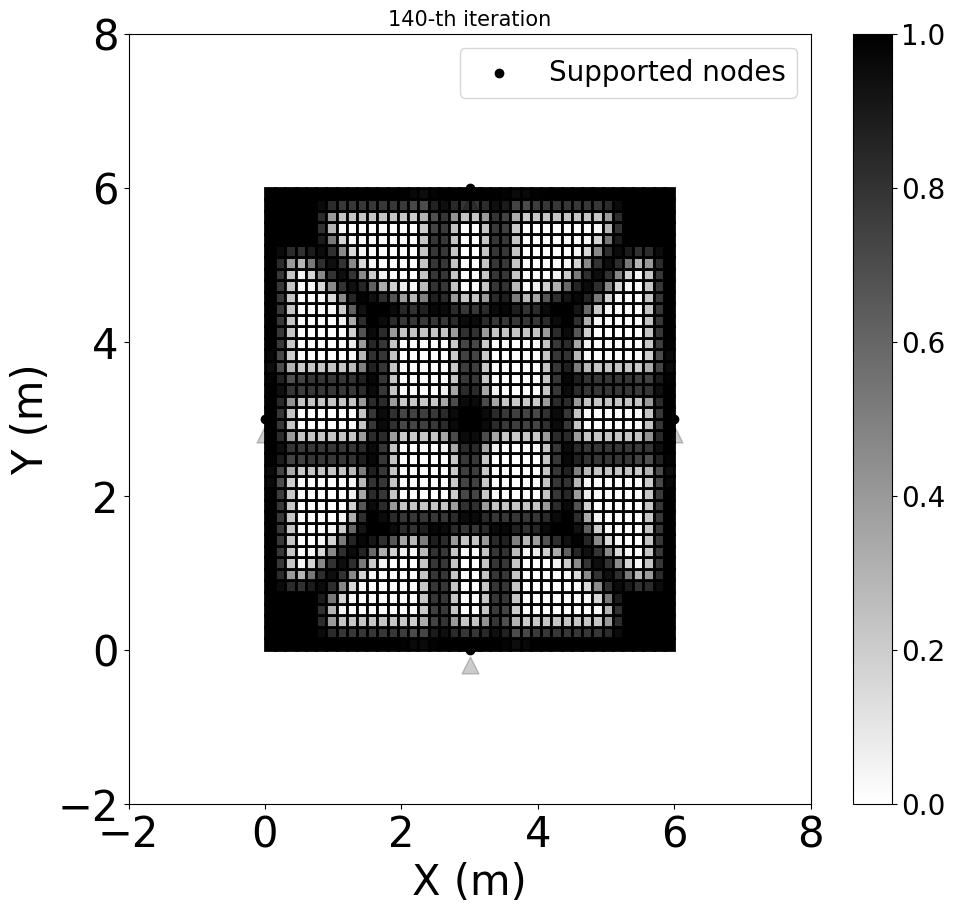

141th iteration, C = 1.6294525659158288 
142th iteration, C = 1.6267566334302572 
143th iteration, C = 2.868519743330365 
144th iteration, C = 1.6701919864328358 
145th iteration, C = 1.6254475426970856 
799.9997552326158


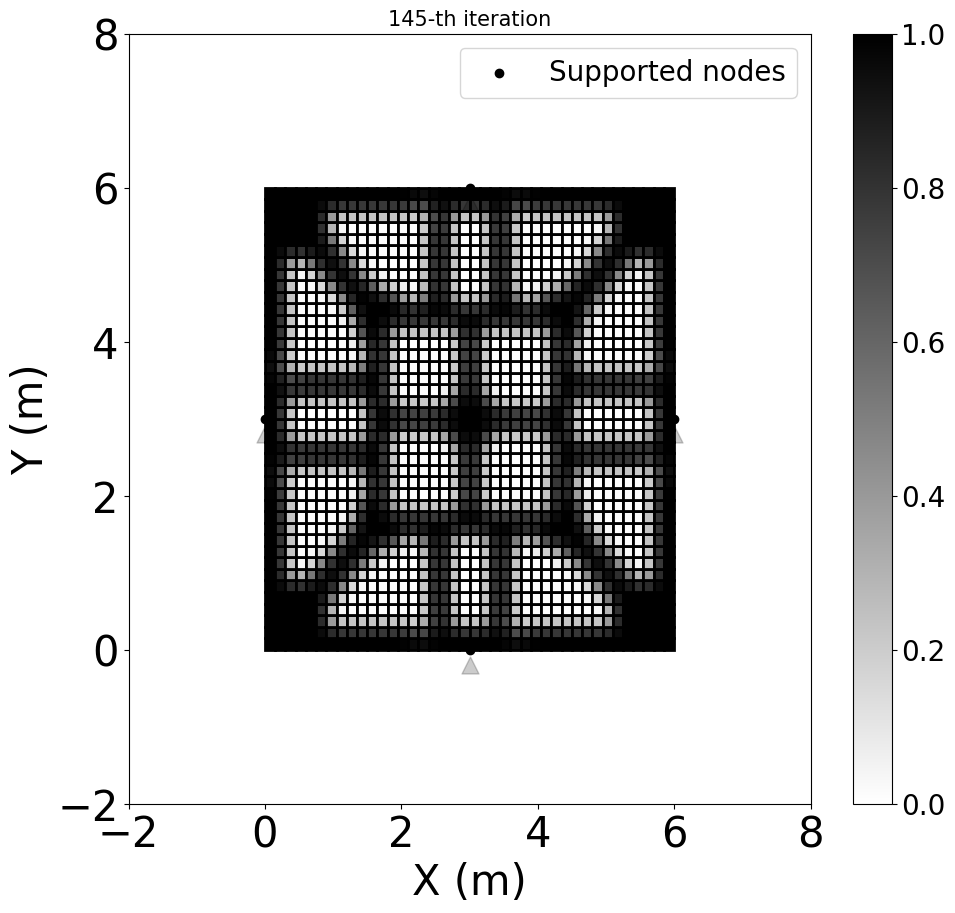

146th iteration, C = 1.6230337877709256 
147th iteration, C = 2.067944458173479 
148th iteration, C = 1.6389420811897986 
149th iteration, C = 1.6224562308449066 
150th iteration, C = 1.6216995799255787 
799.9887145221503


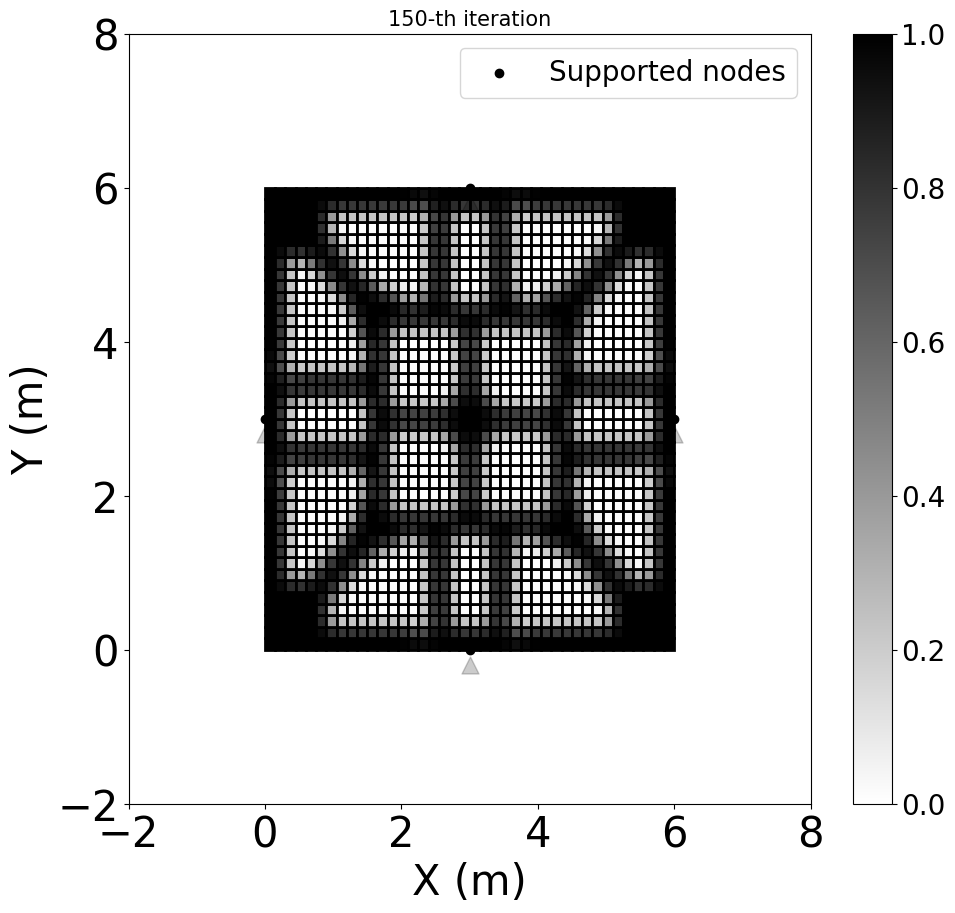

151th iteration, C = 1.6707522255914162 
152th iteration, C = 1.6198470228043278 
153th iteration, C = 1.6194181571310362 
154th iteration, C = 1.6191521898970584 
155th iteration, C = 1.6183791342801264 
799.9995365058517


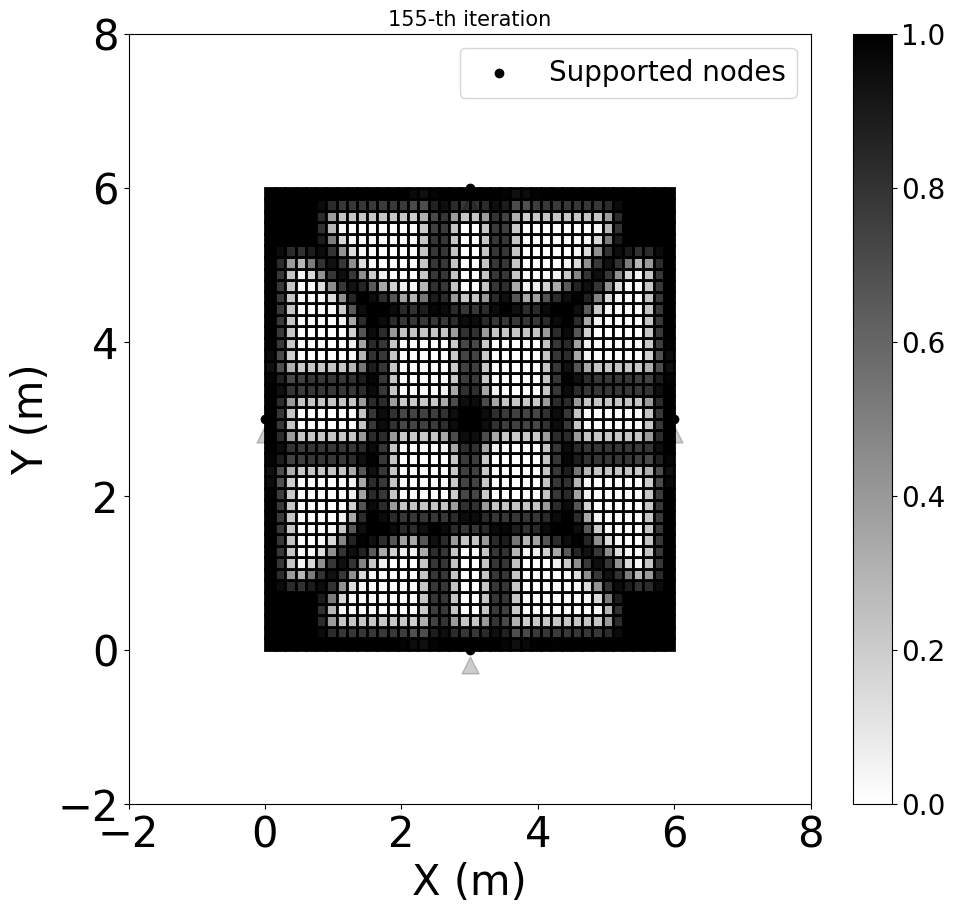

156th iteration, C = 1.6180178199118882 
157th iteration, C = 1.6172848397014337 
158th iteration, C = 1.6385535037816696 
159th iteration, C = 1.6172369483775142 
160th iteration, C = 1.6208141908055271 
799.9988866137905


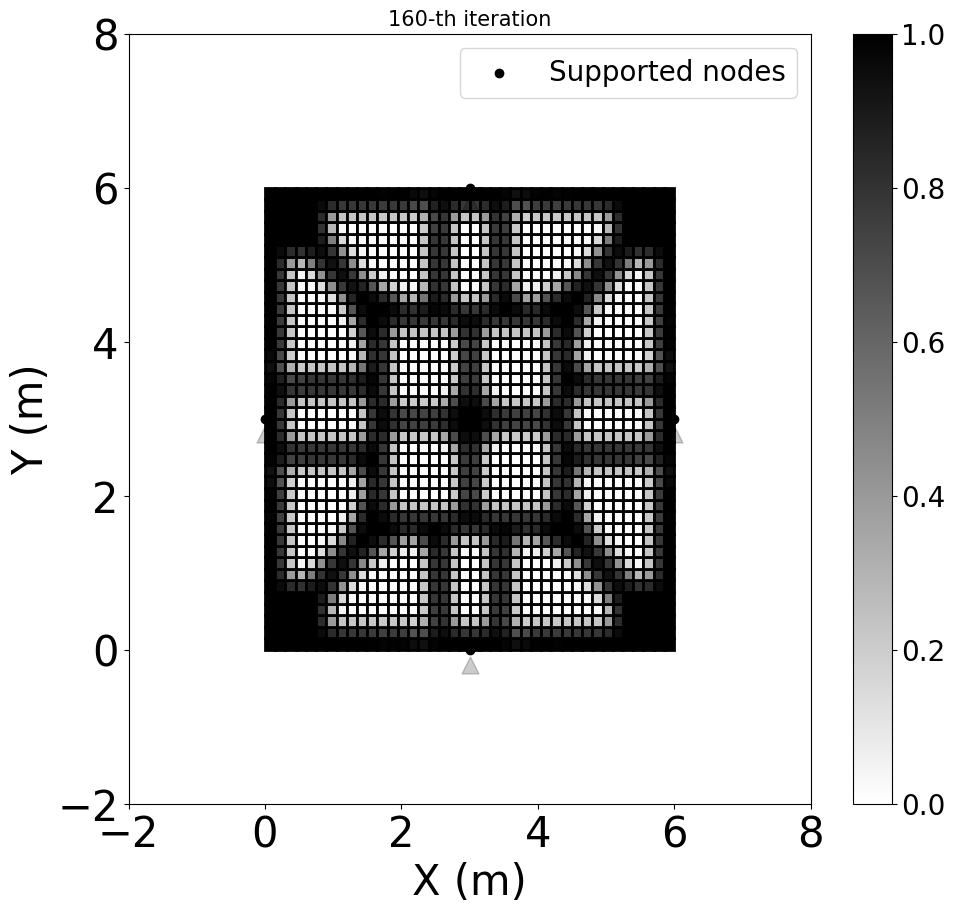

161th iteration, C = 1.6162311716275333 
162th iteration, C = 1.6152744342851395 
163th iteration, C = 1.9616506731461296 
164th iteration, C = 1.6282916211184308 
165th iteration, C = 1.6146673866124135 
799.9997078054323


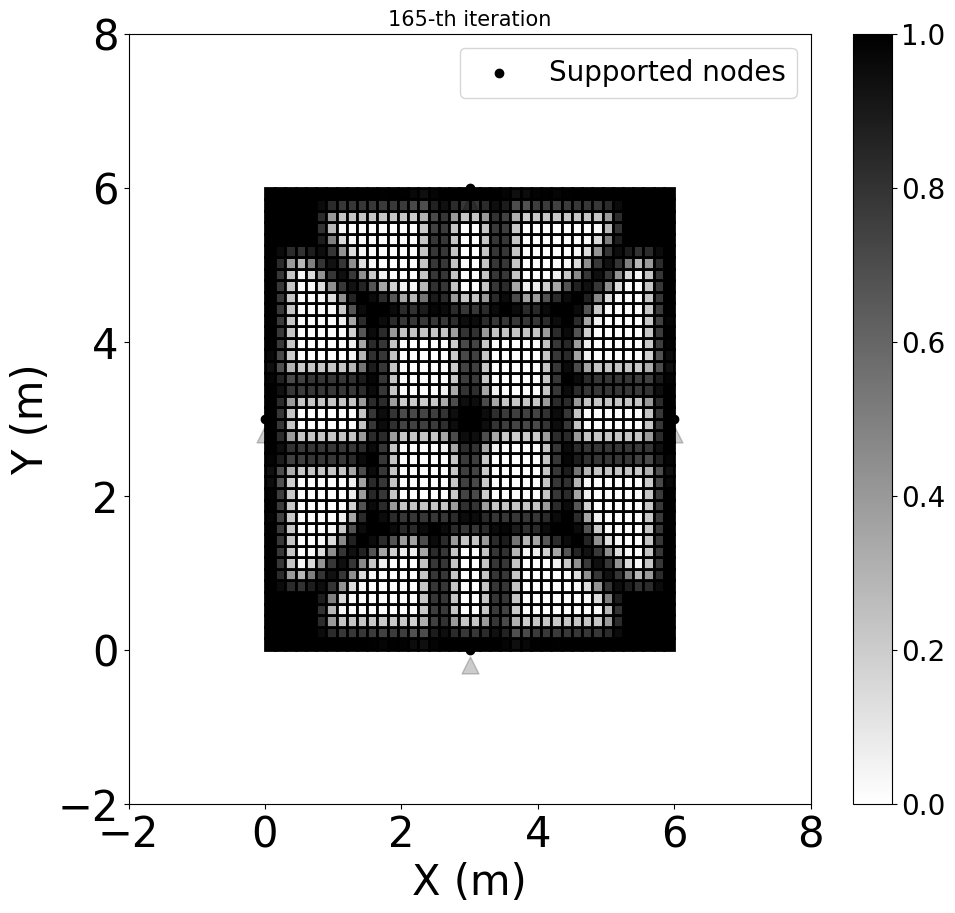

166th iteration, C = 1.6137720771000377 
167th iteration, C = 1.6483211650583238 
168th iteration, C = 1.6125137387638637 
169th iteration, C = 1.6120795430605852 
170th iteration, C = 1.6116042751056472 
799.9975146612089


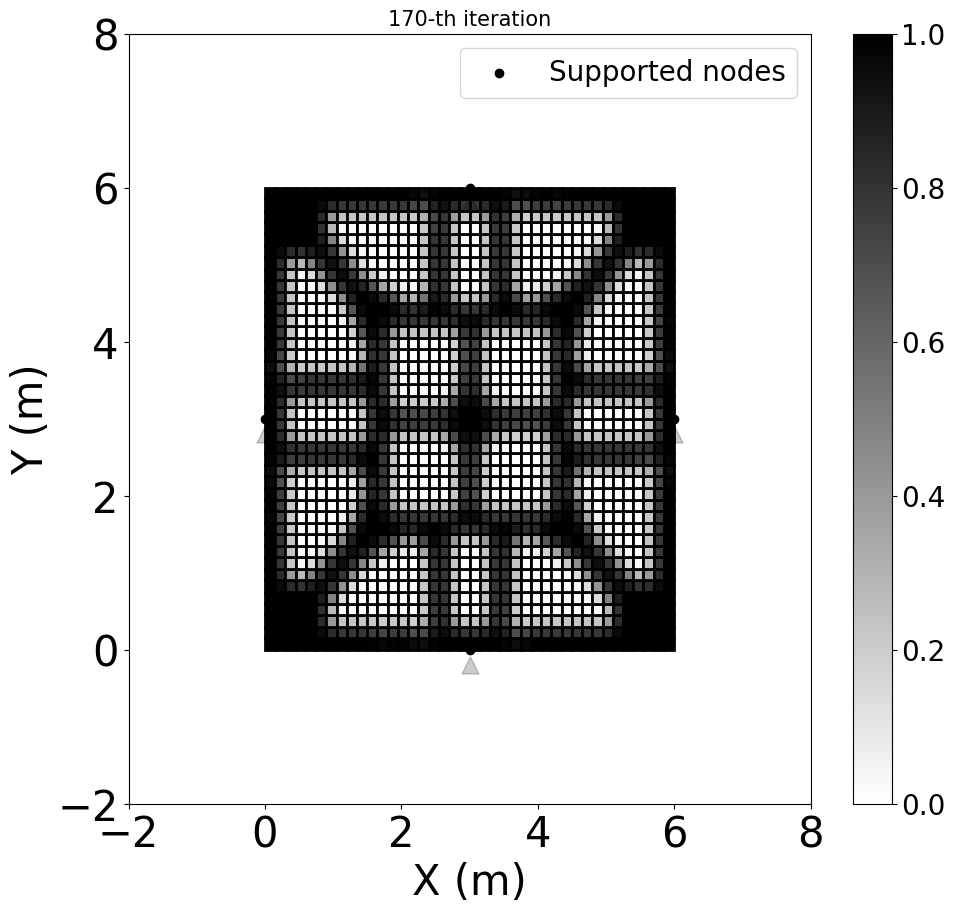

171th iteration, C = 1.622896741260434 
172th iteration, C = 1.6109711107748146 
173th iteration, C = 1.6105197893576302 
174th iteration, C = 1.6123792877237662 
175th iteration, C = 1.6096851014507692 
799.9997862638558


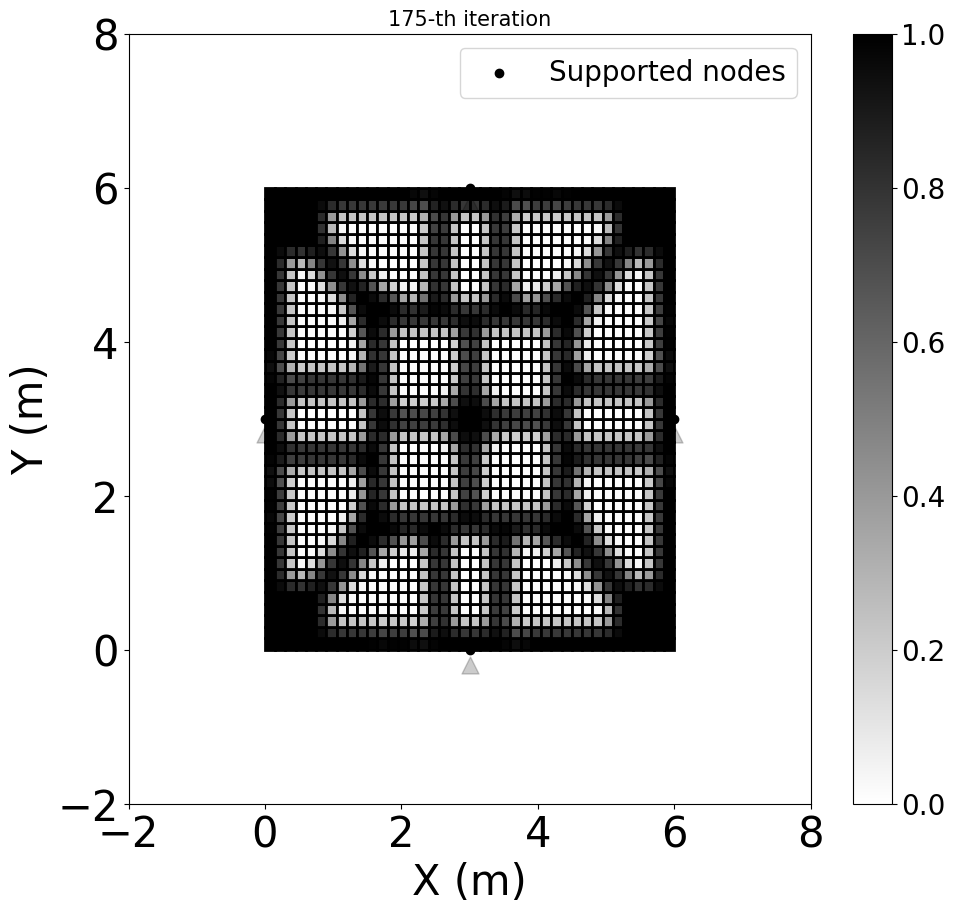

176th iteration, C = 1.608001899106124 
177th iteration, C = 1.7339864513809766 
178th iteration, C = 1.6093452955247125 
179th iteration, C = 1.6075046509926825 
180th iteration, C = 1.6112964284003306 
799.9957097123175


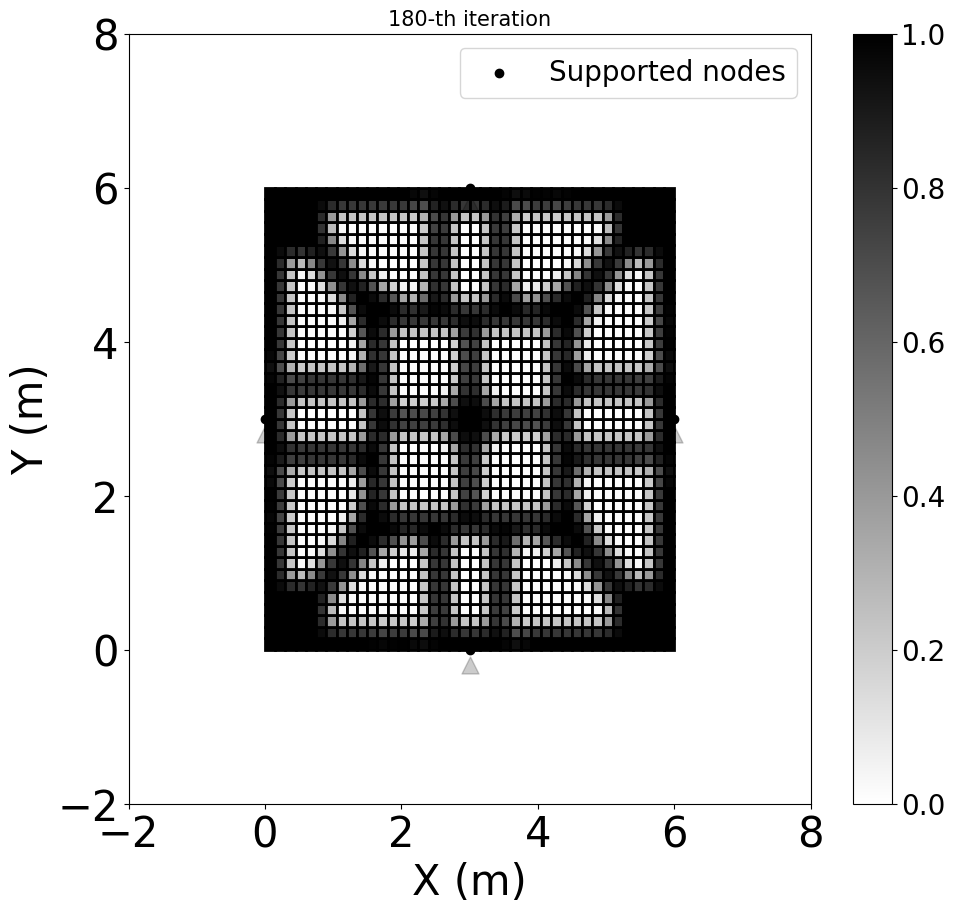

181th iteration, C = 1.606749293819373 
182th iteration, C = 1.6114886645653512 
183th iteration, C = 1.606153834116135 
184th iteration, C = 1.6045524826347963 
185th iteration, C = 2.1524560064793596 
799.9695160144076


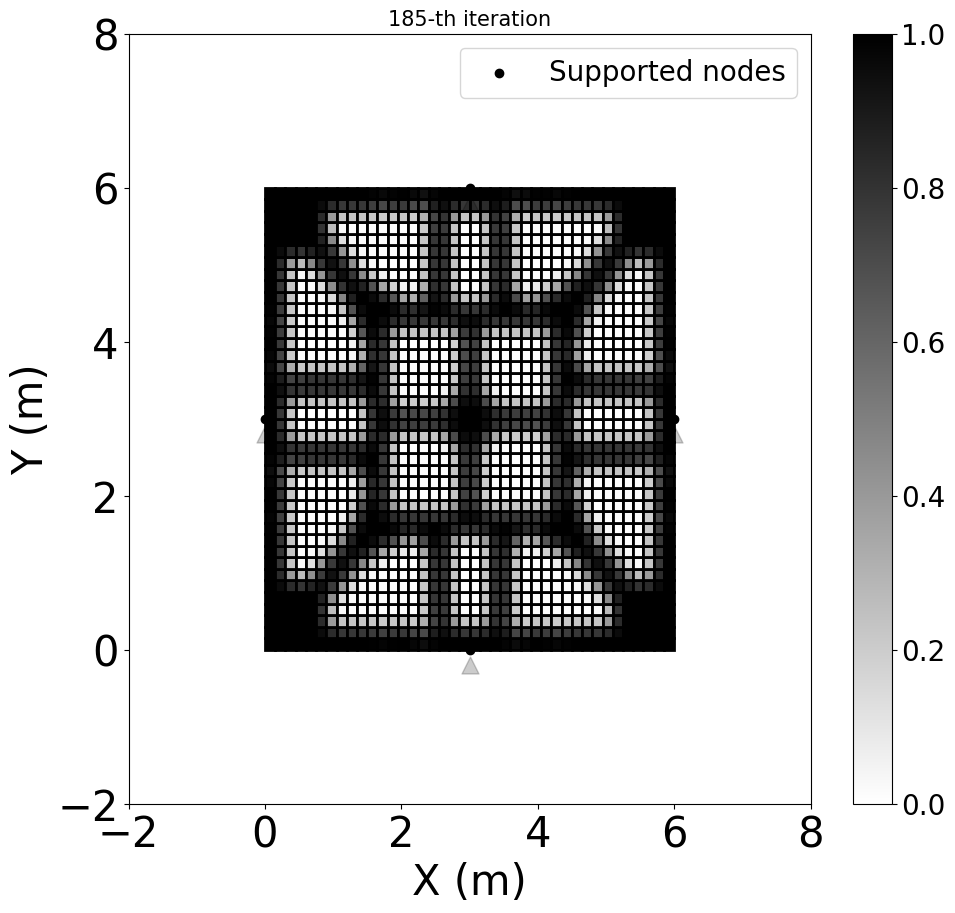

186th iteration, C = 1.6337499292154685 
187th iteration, C = 1.604032432092983 
188th iteration, C = 1.6023311395455275 
189th iteration, C = 1.708153132524754 
190th iteration, C = 1.6075944869648686 
799.9982232566168


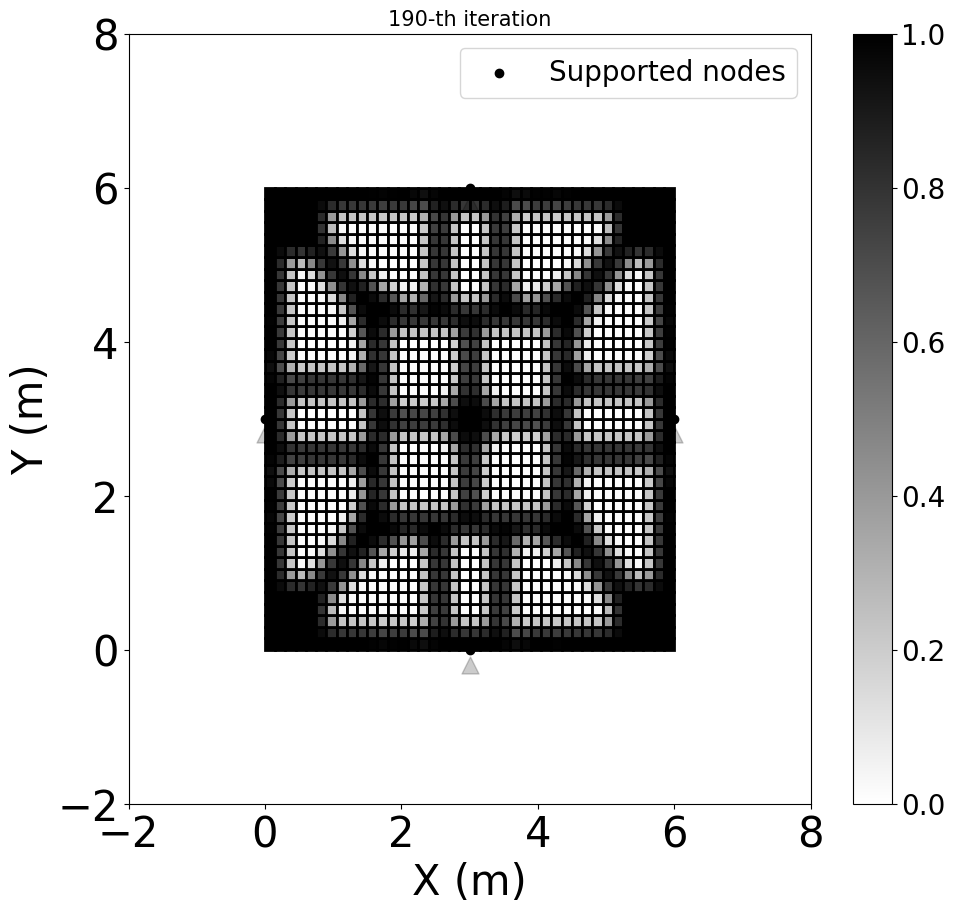

191th iteration, C = 1.6019527790553398 
192th iteration, C = 1.6373054922294188 
193th iteration, C = 1.601964116313958 
194th iteration, C = 1.601772020290614 
195th iteration, C = 1.6030029857770227 
799.9994064692921


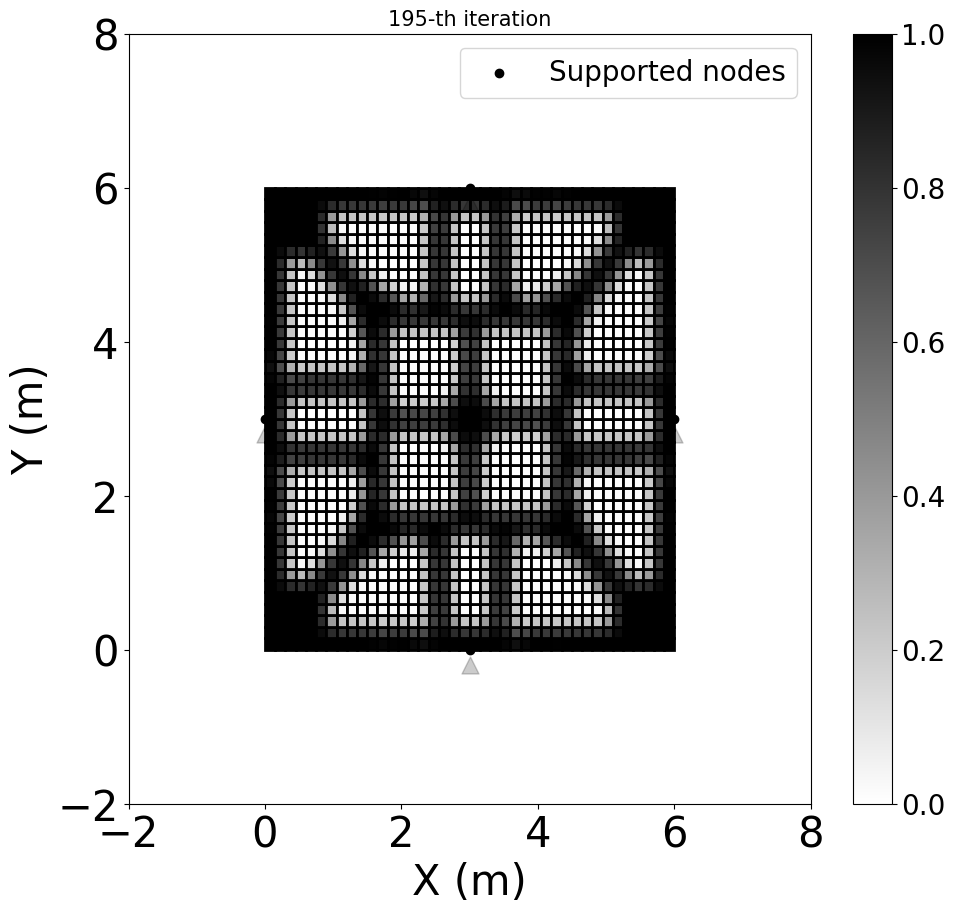

196th iteration, C = 1.6015441407584767 
197th iteration, C = 1.6147277690719117 
198th iteration, C = 1.6012535800860495 
199th iteration, C = 1.6010090680791826 
200th iteration, C = 1.6007910718268925 
799.9999550797347


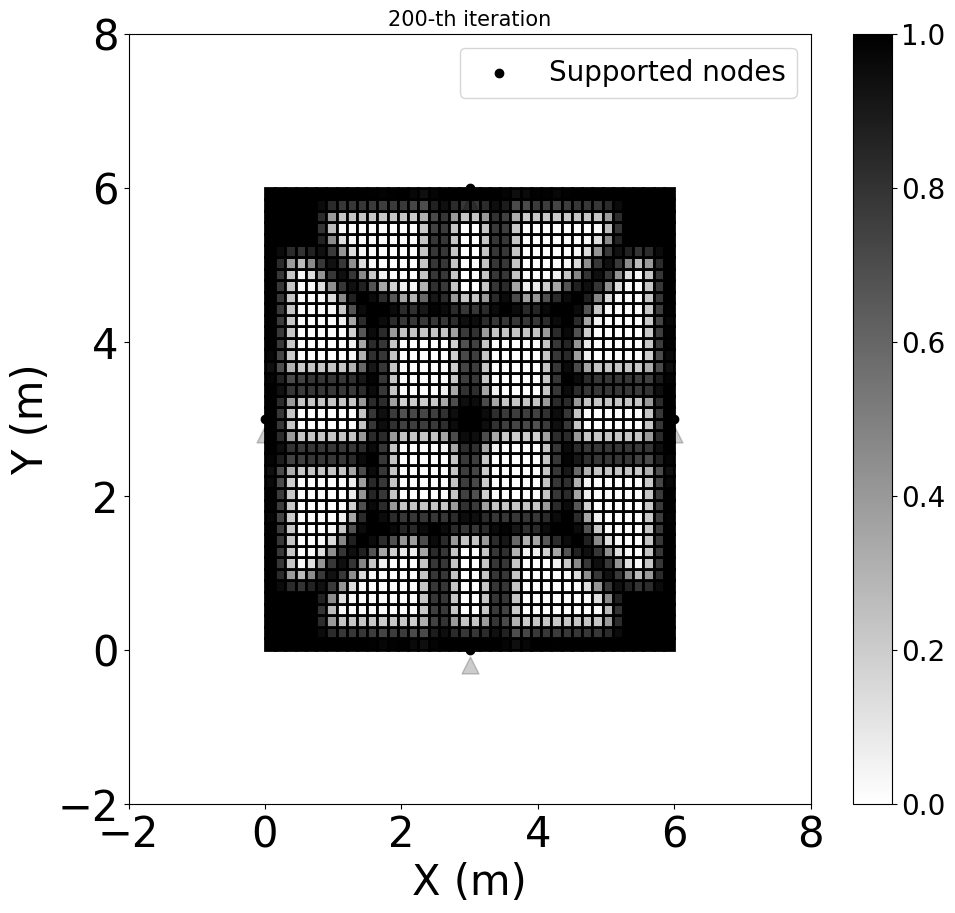

201th iteration, C = 1.6018578570672573 
202th iteration, C = 1.6003520520433596 
203th iteration, C = 1.6898454741125437 
204th iteration, C = 1.6007084117482775 
205th iteration, C = 1.6000452348546932 
799.9999303445602


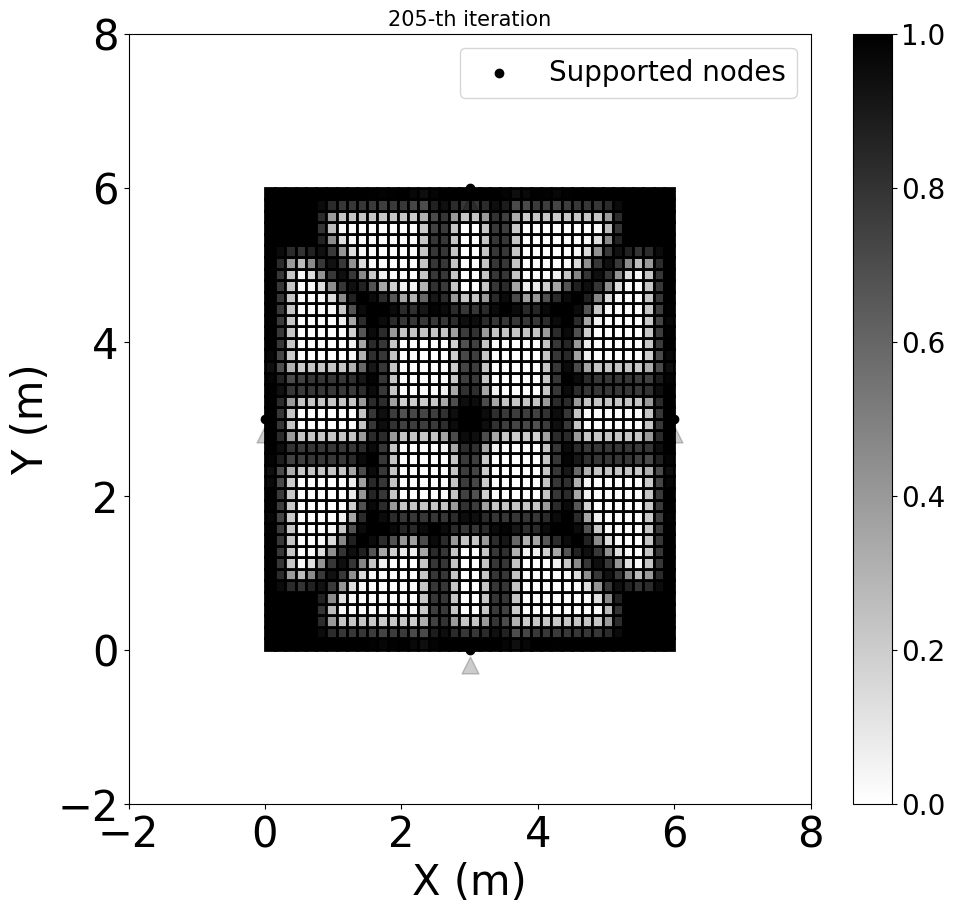

206th iteration, C = 1.5997800532474338 
207th iteration, C = 1.6402390610056747 
208th iteration, C = 1.598673218436203 
209th iteration, C = 1.598248843660172 
210th iteration, C = 1.5989597589275422 
799.9993034382419


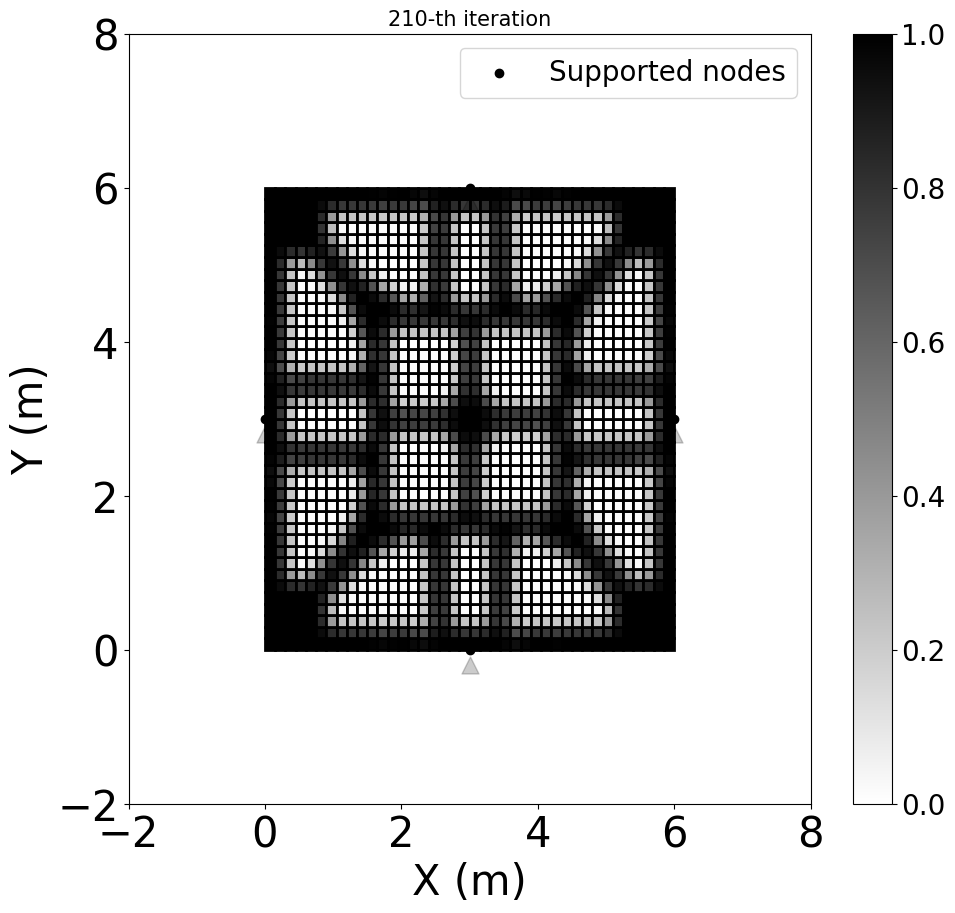

211th iteration, C = 1.597780776770422 
212th iteration, C = 1.5984557653605032 
213th iteration, C = 1.5975893579886429 
214th iteration, C = 1.5976822500916212 
215th iteration, C = 1.5973939980408256 
799.9999903010122


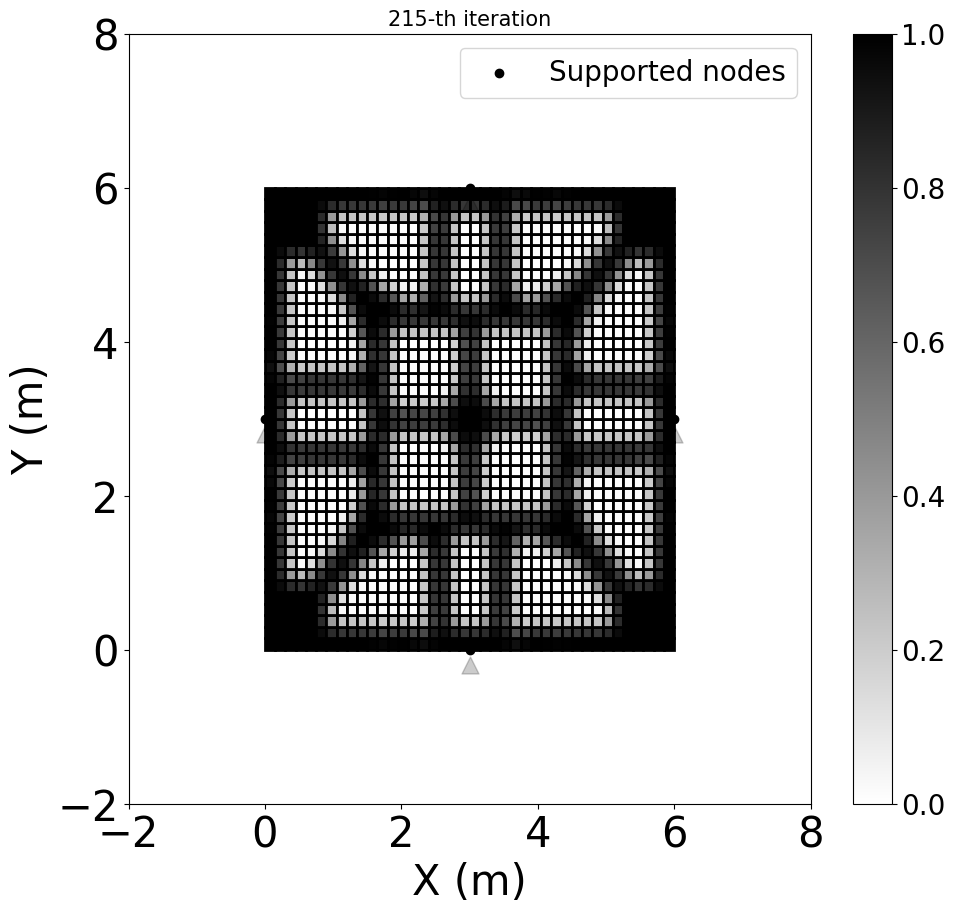

216th iteration, C = 1.5972617376671048 
217th iteration, C = 1.6109275547272173 
218th iteration, C = 1.596761094085463 
219th iteration, C = 1.596681546395388 
220th iteration, C = 1.5987155042614554 
799.9998910373138


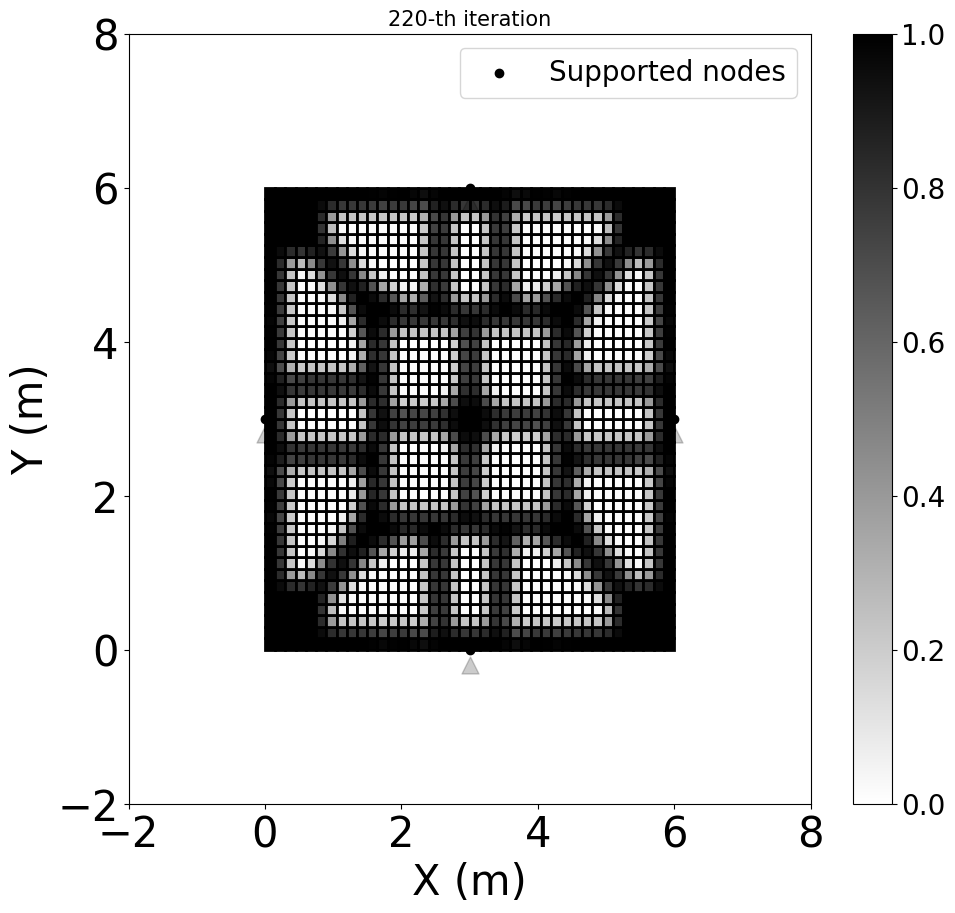

221th iteration, C = 1.5963370241983974 
222th iteration, C = 1.5960173199322318 
223th iteration, C = 1.5991781996686434 
224th iteration, C = 1.5957024436982692 
225th iteration, C = 1.5954180592178466 
799.9989642503554


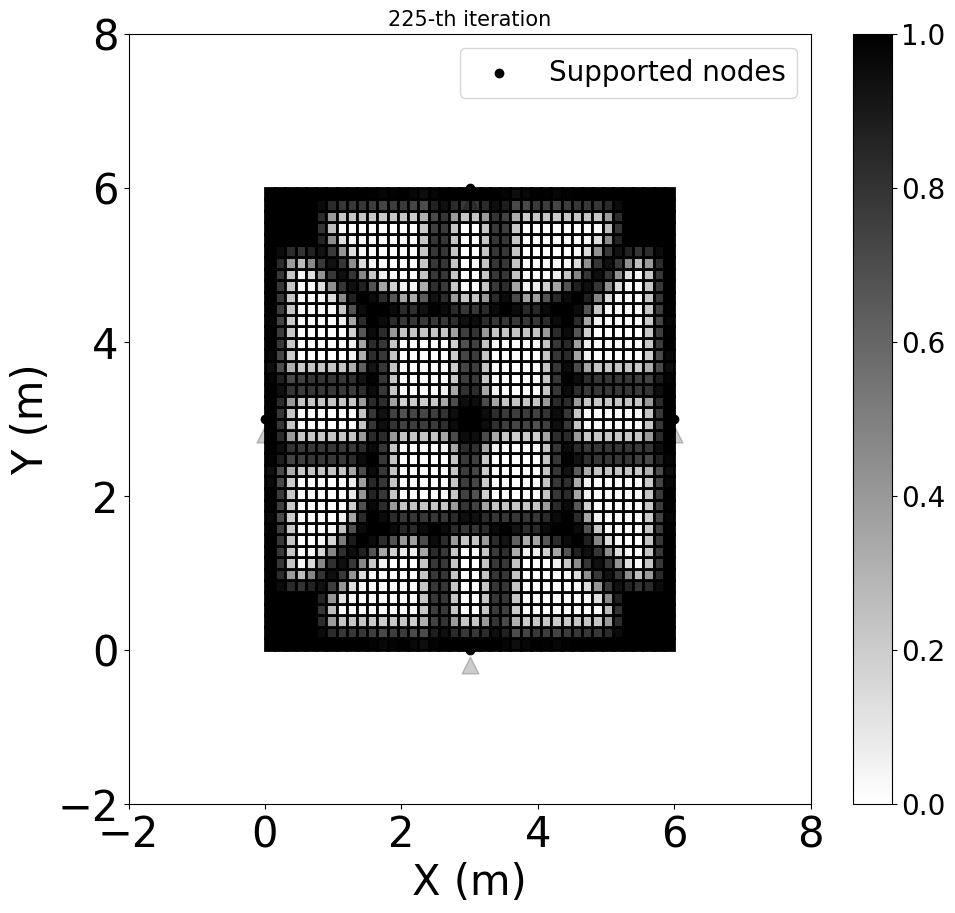

226th iteration, C = 1.6031216197070768 
227th iteration, C = 1.5950660904709568 
228th iteration, C = 1.594842344053846 
229th iteration, C = 1.5974044921273385 
230th iteration, C = 1.5945416828732581 
799.9999296880952


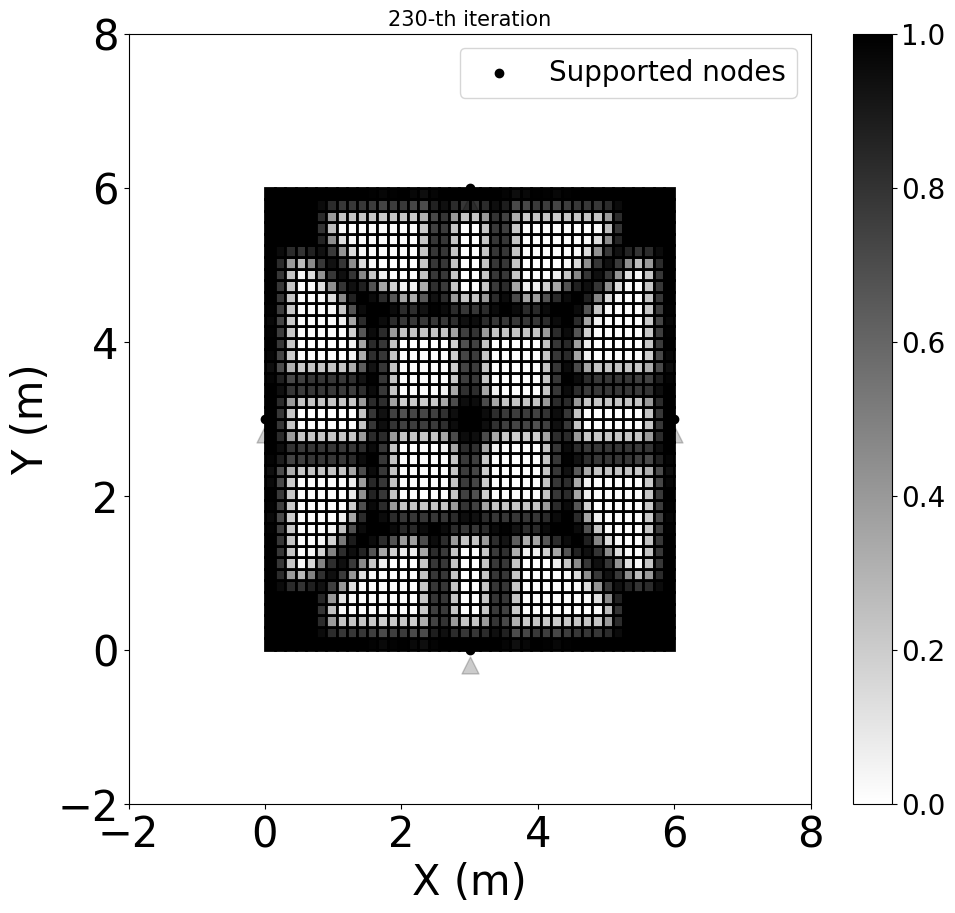

231th iteration, C = 1.5945804834498576 
232th iteration, C = 1.594315146047246 
233th iteration, C = 1.6787251931452392 
234th iteration, C = 1.5956507420307267 
235th iteration, C = 1.5942017842619494 
799.9999590106827


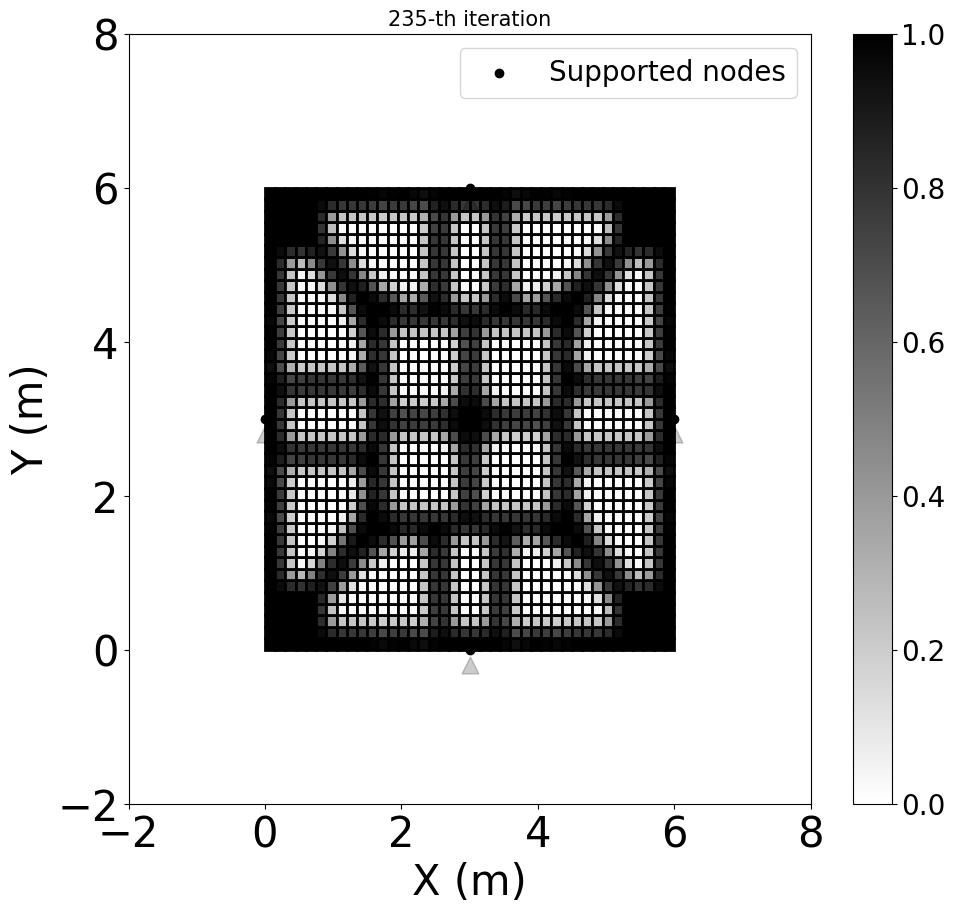

236th iteration, C = 1.5942716445591123 
237th iteration, C = 1.5939977161596912 
238th iteration, C = 1.6332074873970204 
239th iteration, C = 1.5939377044411502 
240th iteration, C = 1.5941510739293066 
799.9996736617027


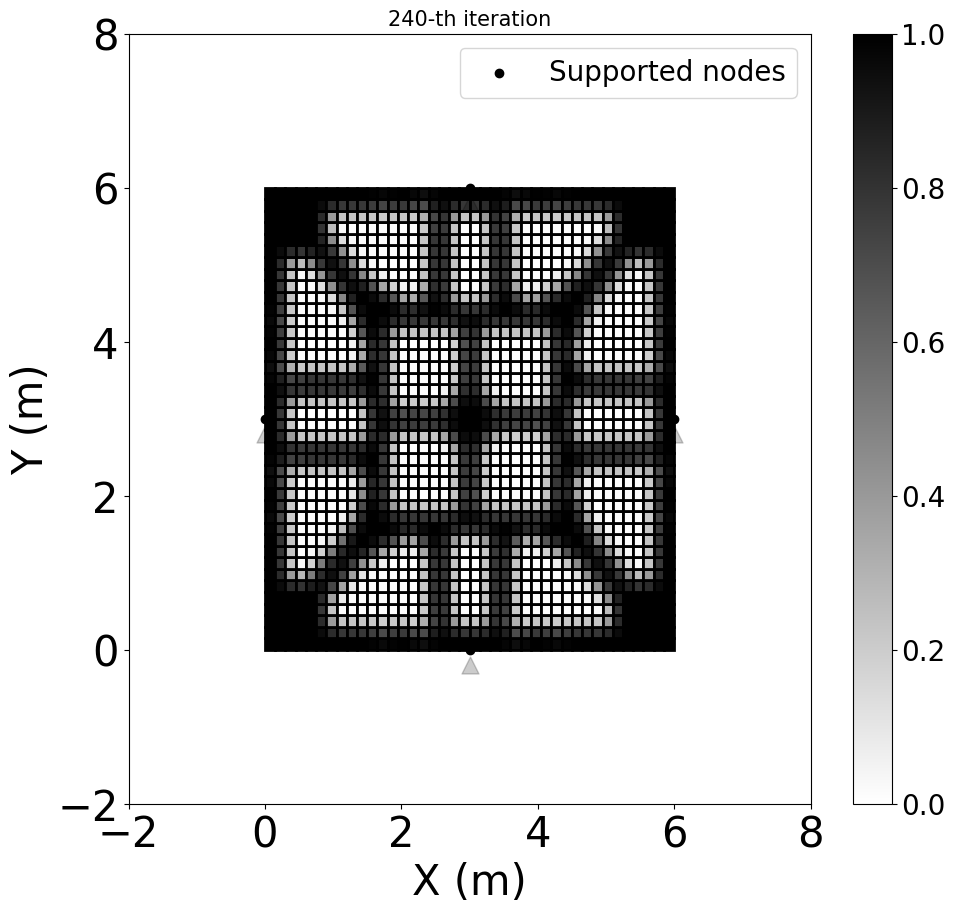

241th iteration, C = 1.593618877257643 
242th iteration, C = 1.5932957884010504 
243th iteration, C = 1.6004009245411404 
244th iteration, C = 1.5929705888943153 
245th iteration, C = 1.5928696008417453 
799.9999724089603


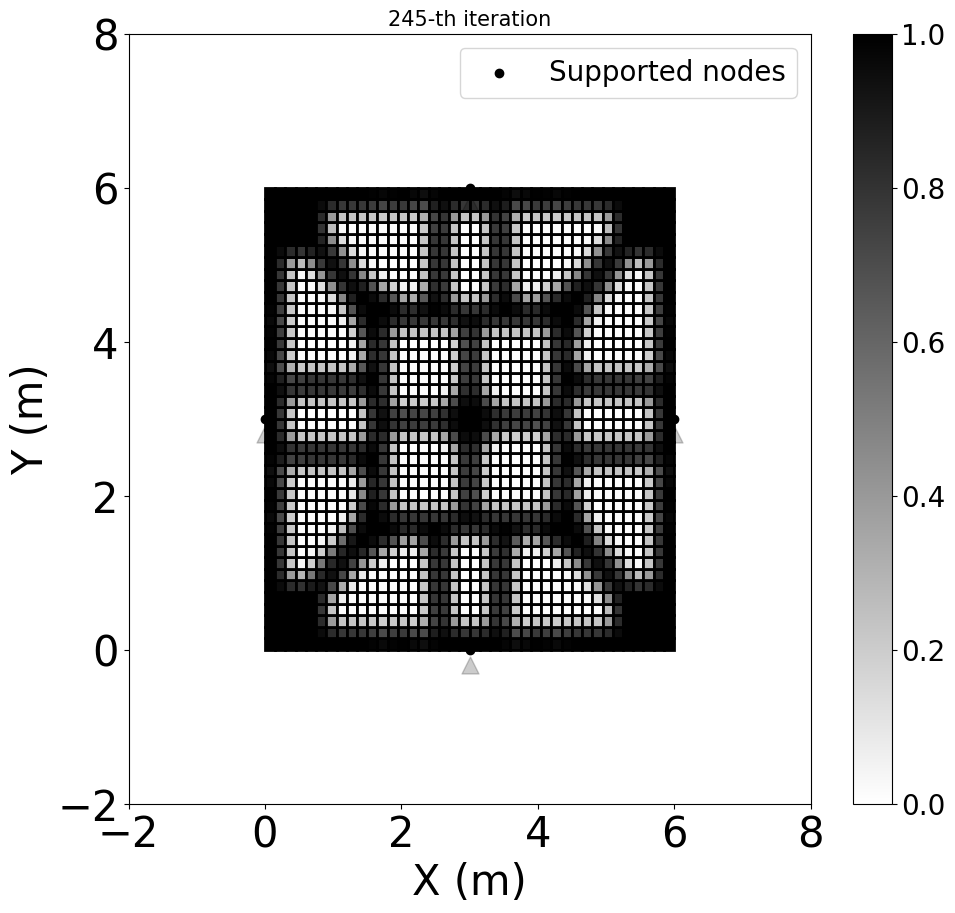

246th iteration, C = 1.5924660809425744 
247th iteration, C = 1.7002848440918719 
248th iteration, C = 1.5947762165138175 
249th iteration, C = 1.5923306303179596 
250th iteration, C = 1.5921703900815154 
799.996066324625


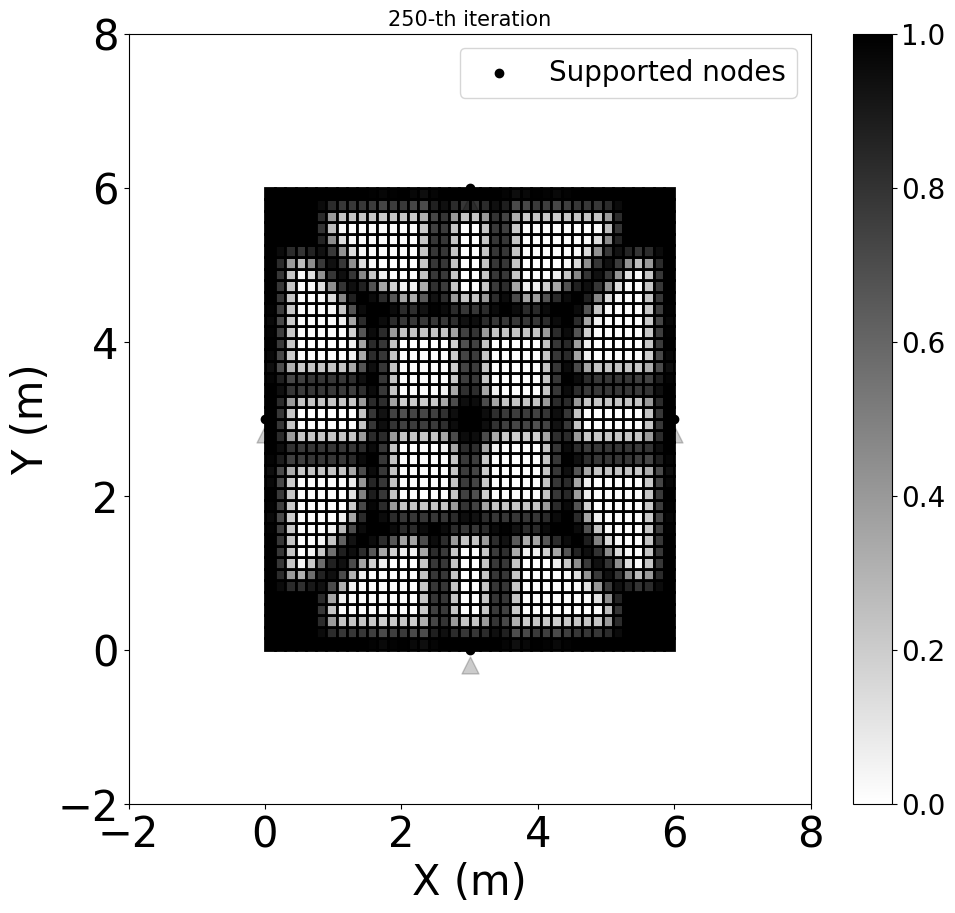

251th iteration, C = 1.6051243411968106 
252th iteration, C = 1.5916326415346362 
253th iteration, C = 1.5912517833871989 
254th iteration, C = 1.5930345889284638 
255th iteration, C = 1.591029518156492 
799.9999317494419


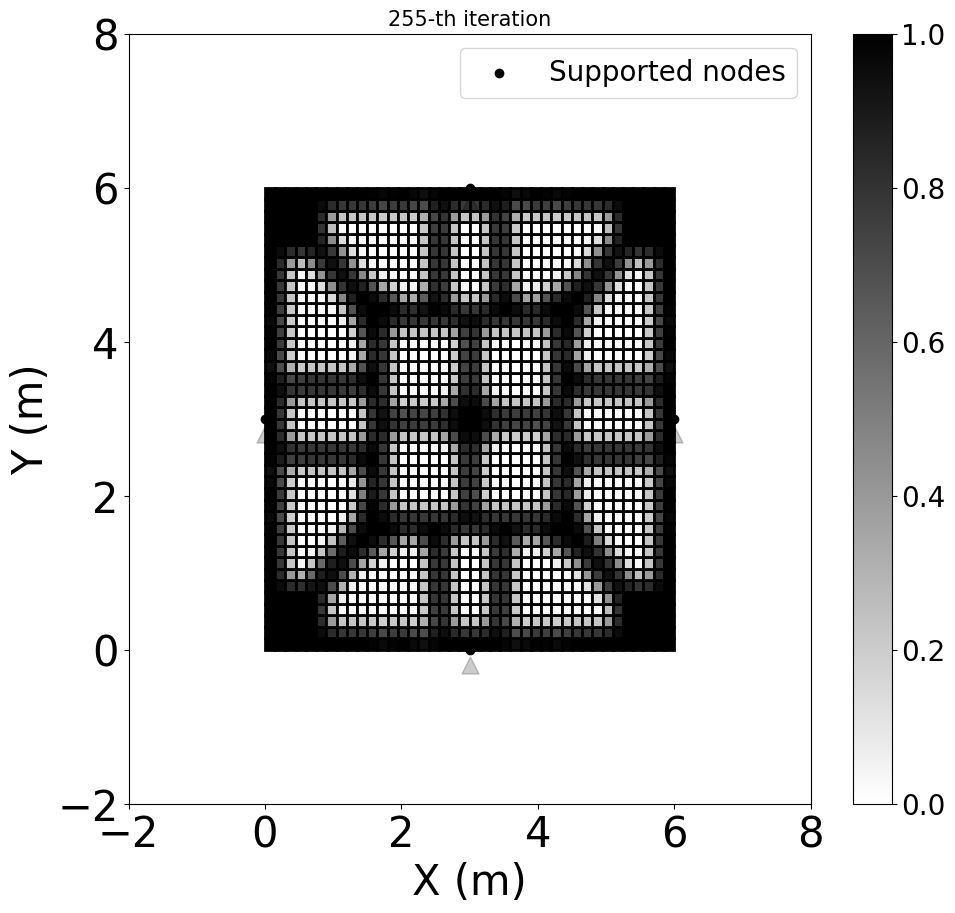

256th iteration, C = 1.5921022255056922 
257th iteration, C = 1.5908922789120286 
258th iteration, C = 1.5911960276805484 
259th iteration, C = 1.5907737707071747 
260th iteration, C = 1.5906219240697361 
799.9990222825718


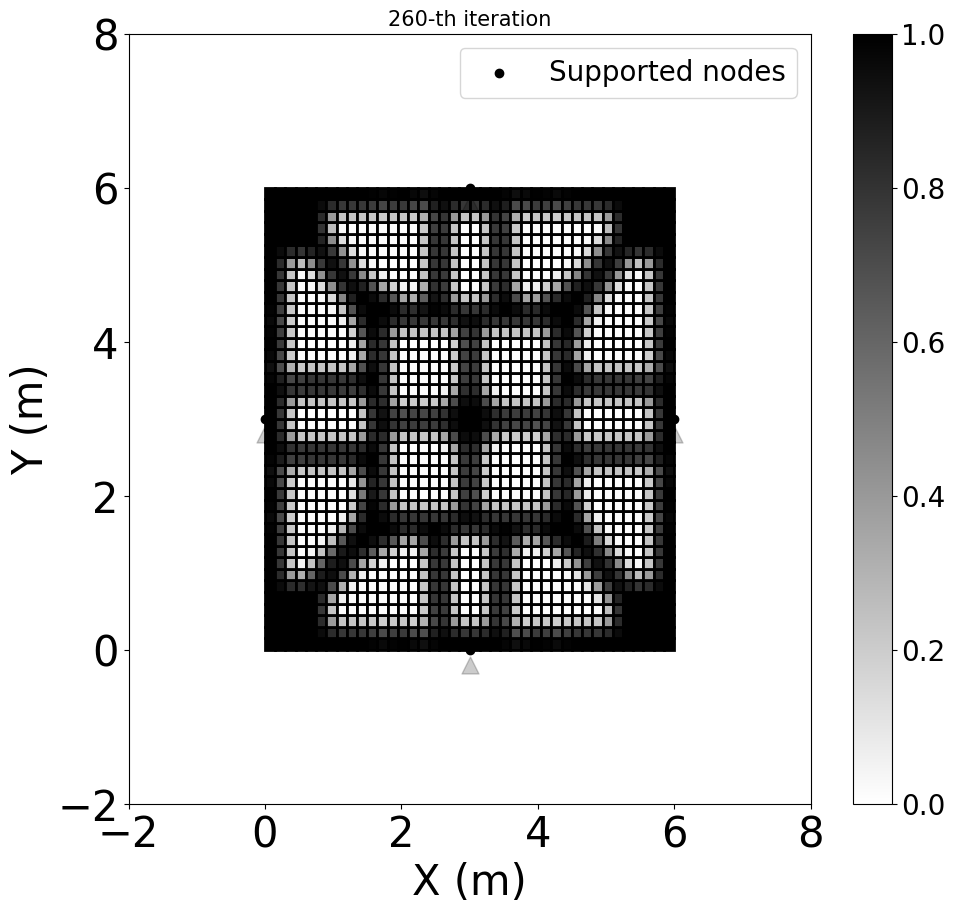

261th iteration, C = 1.600459116206024 
262th iteration, C = 1.5903315295467508 
263th iteration, C = 1.5902818178292004 
264th iteration, C = 1.5900214344534656 
265th iteration, C = 1.6396500200679003 
799.9839137108152


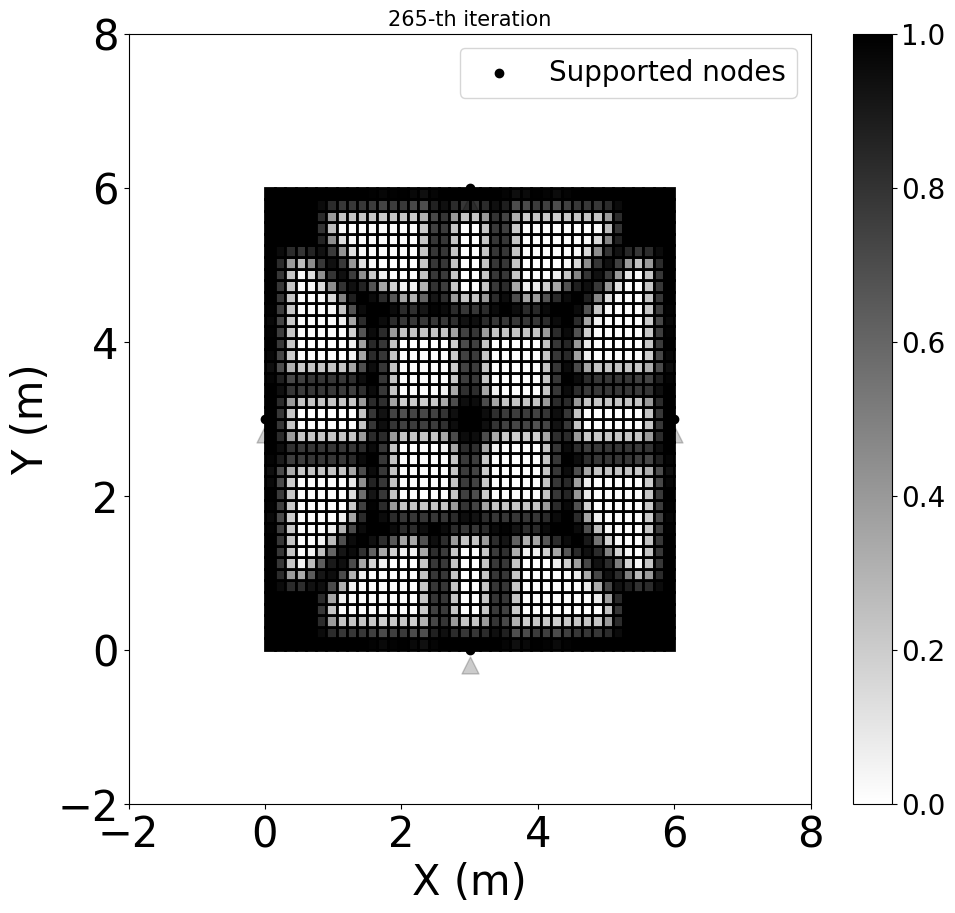

266th iteration, C = 1.5907179178973478 
267th iteration, C = 1.5899006103015227 
268th iteration, C = 1.5898444048220146 
269th iteration, C = 1.598990002079014 
270th iteration, C = 1.58920595434327 
799.9999301271307


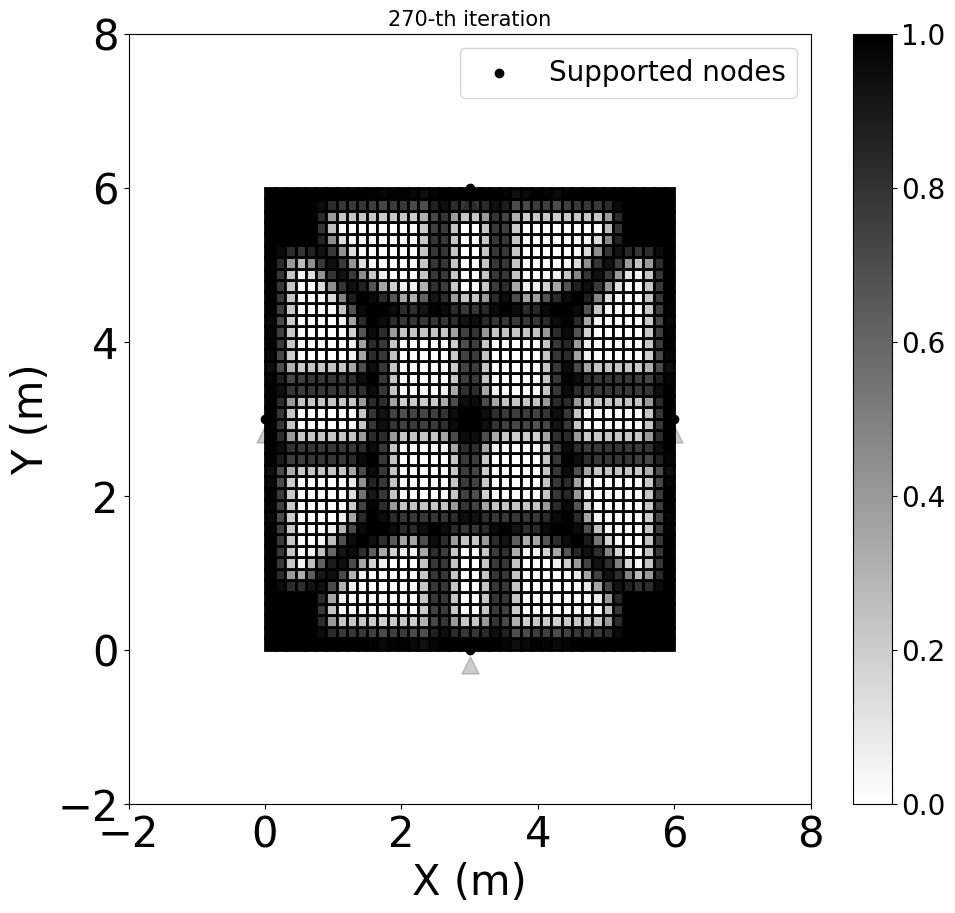

271th iteration, C = 1.589121612701478 
272th iteration, C = 1.5888453947890595 
273th iteration, C = 1.596388020245027 
274th iteration, C = 1.5886410084351303 
275th iteration, C = 1.5883363076136277 
799.9967428052771


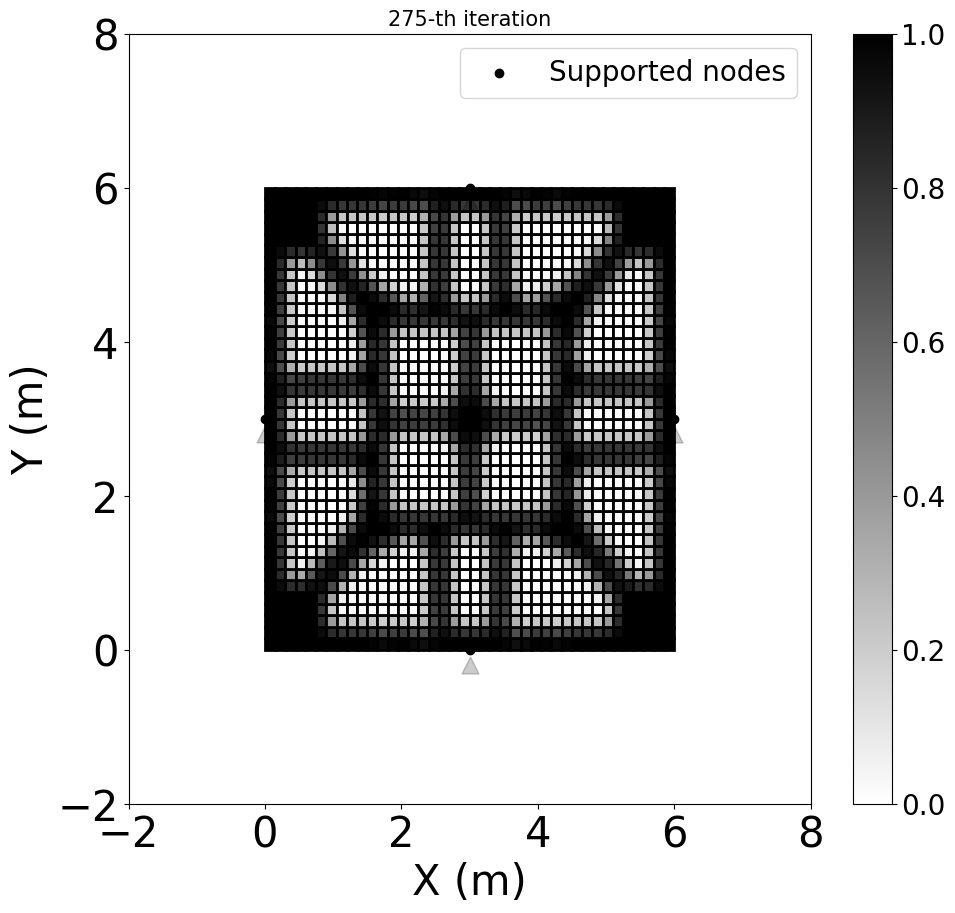

276th iteration, C = 1.5943296061302528 
277th iteration, C = 1.5880810743264056 
278th iteration, C = 1.5884581683828196 
279th iteration, C = 1.5879454393048966 
280th iteration, C = 1.6335614380924575 
799.9862210441845


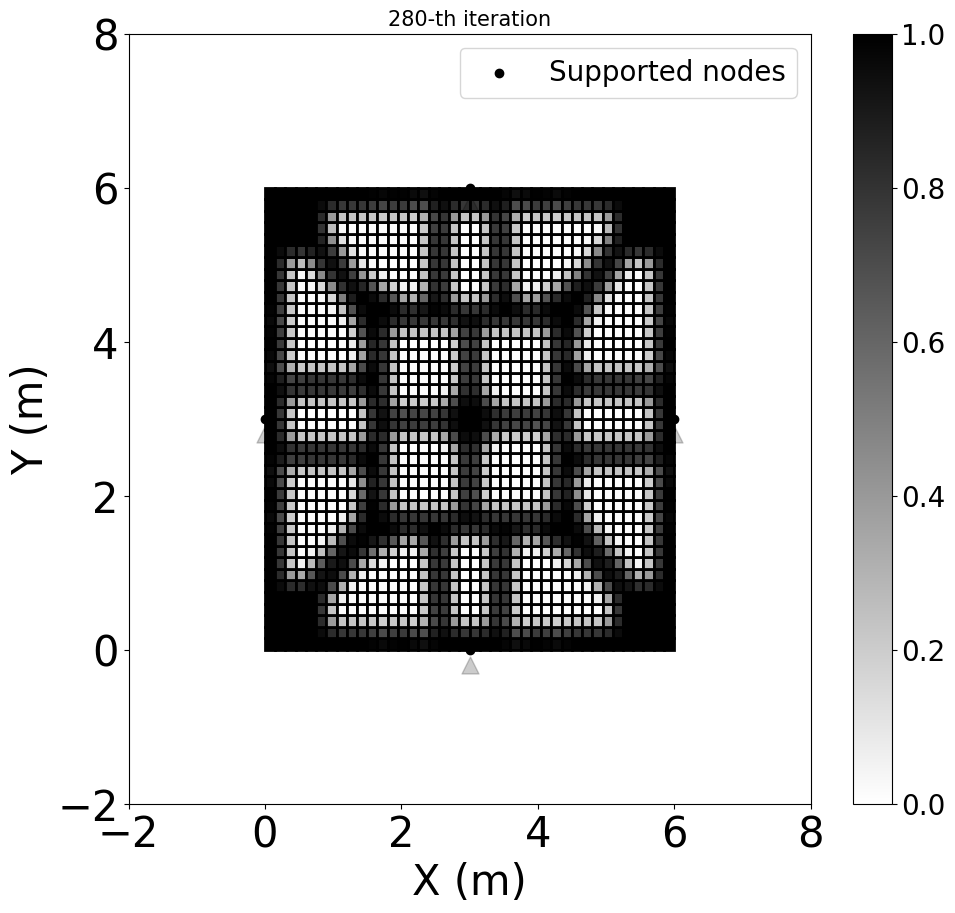

281th iteration, C = 1.588068462265253 
282th iteration, C = 1.5878363219457117 
283th iteration, C = 1.5880575799189593 
284th iteration, C = 1.5876760036586153 
285th iteration, C = 1.6271327620979656 
799.9827883305059


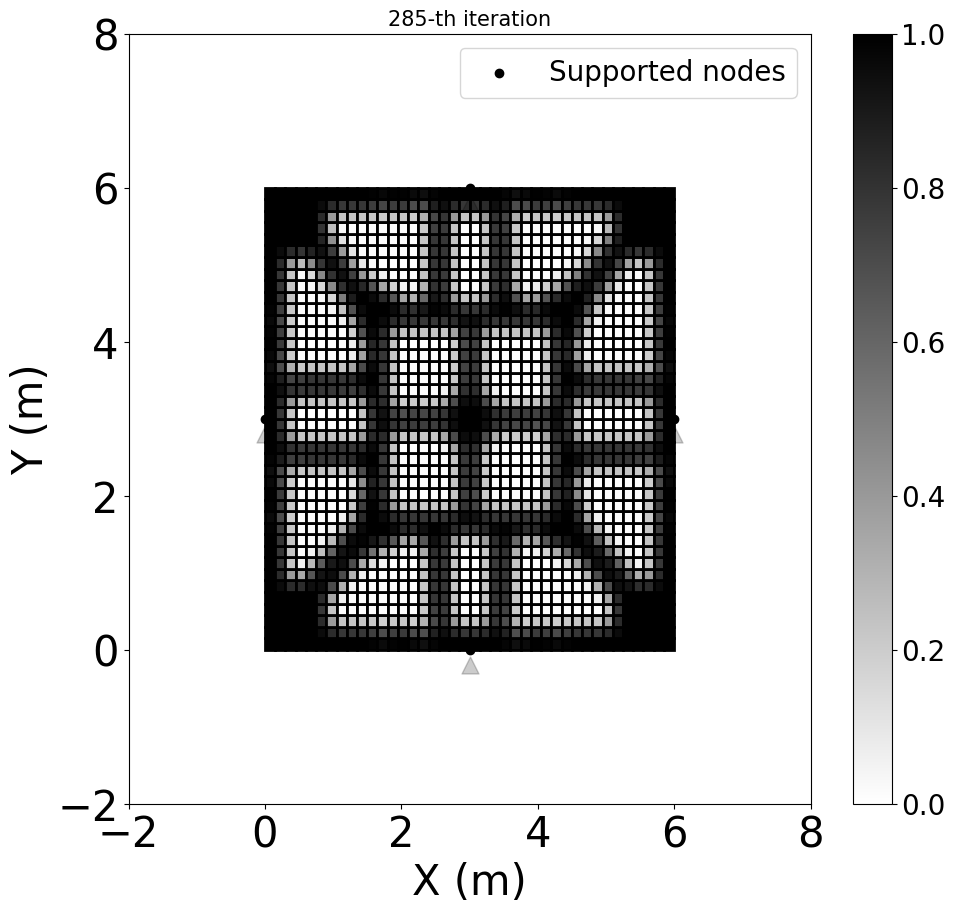

286th iteration, C = 1.587788105255976 
287th iteration, C = 1.5875259396442258 
288th iteration, C = 1.5872469935691156 
289th iteration, C = 1.6005083372156614 
290th iteration, C = 1.5868442721588467 
799.999946434031


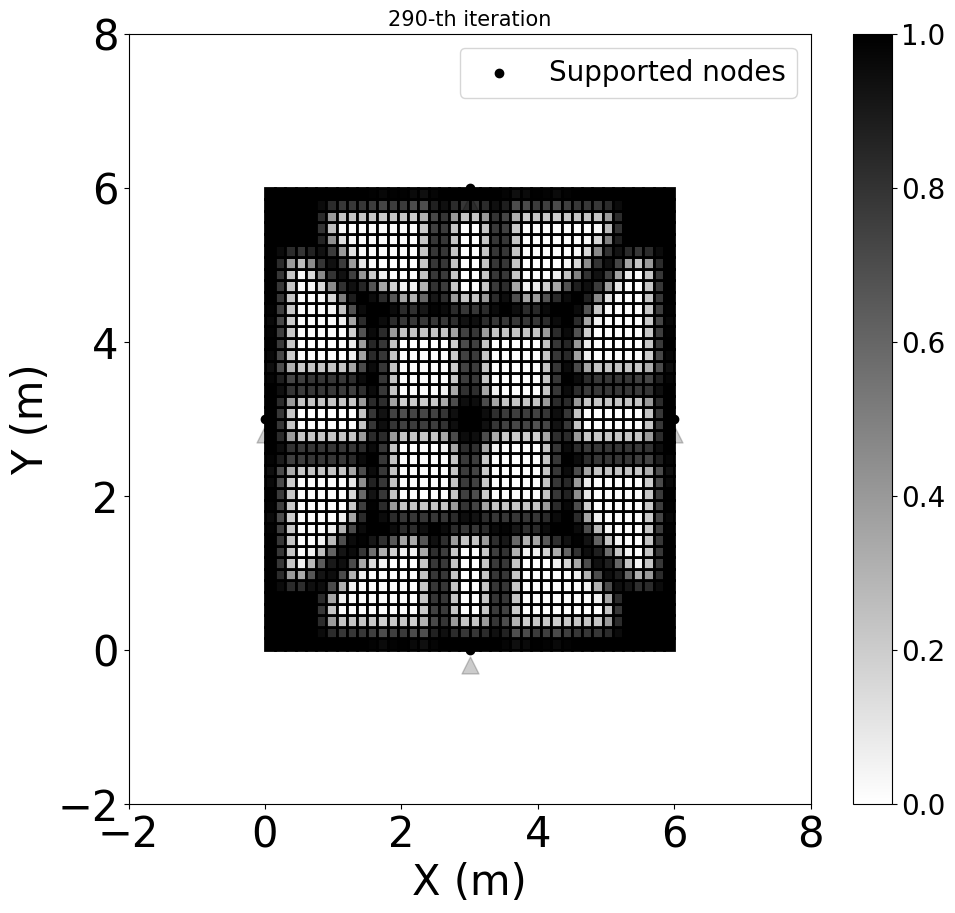

291th iteration, C = 1.5866946223843803 
292th iteration, C = 1.590785210968109 
293th iteration, C = 1.586337762659421 
294th iteration, C = 1.5862348072744825 
295th iteration, C = 1.5861362911760326 
799.9974307569323


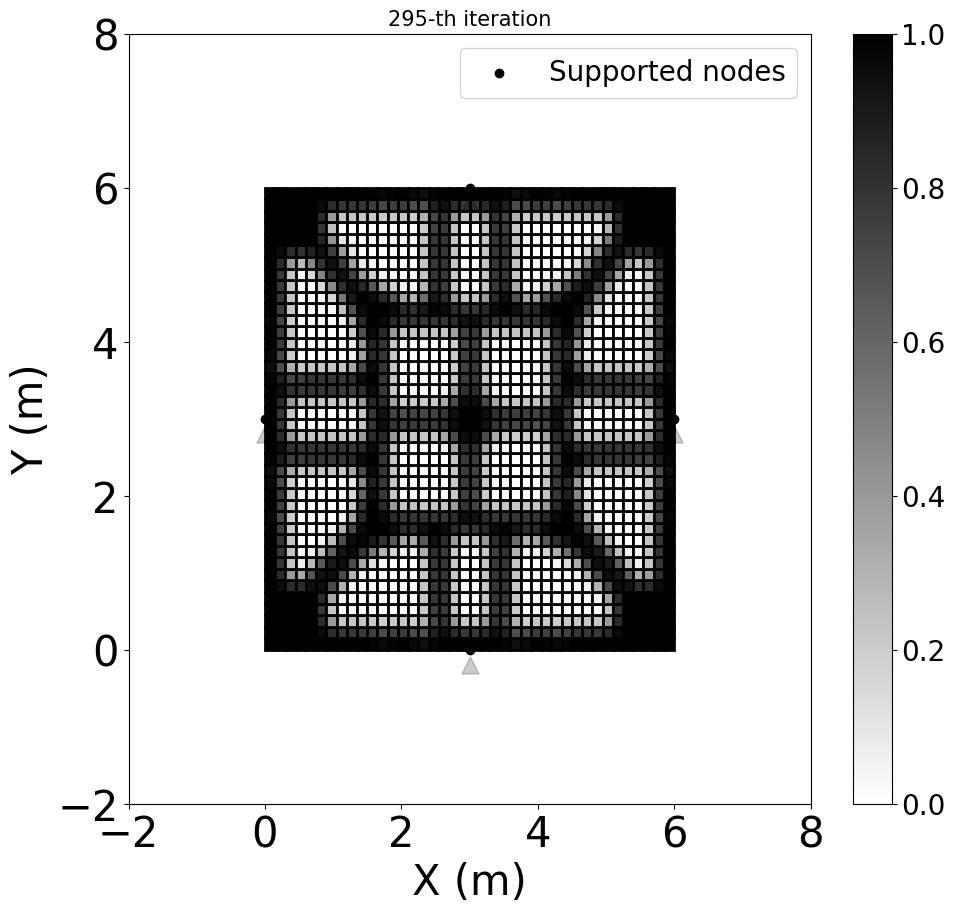

296th iteration, C = 1.5882677696578378 
297th iteration, C = 1.5857890216944395 
298th iteration, C = 1.587788239406934 
299th iteration, C = 1.5856693874172059 
300th iteration, C = 1.5855843623806167 
799.9998679838542


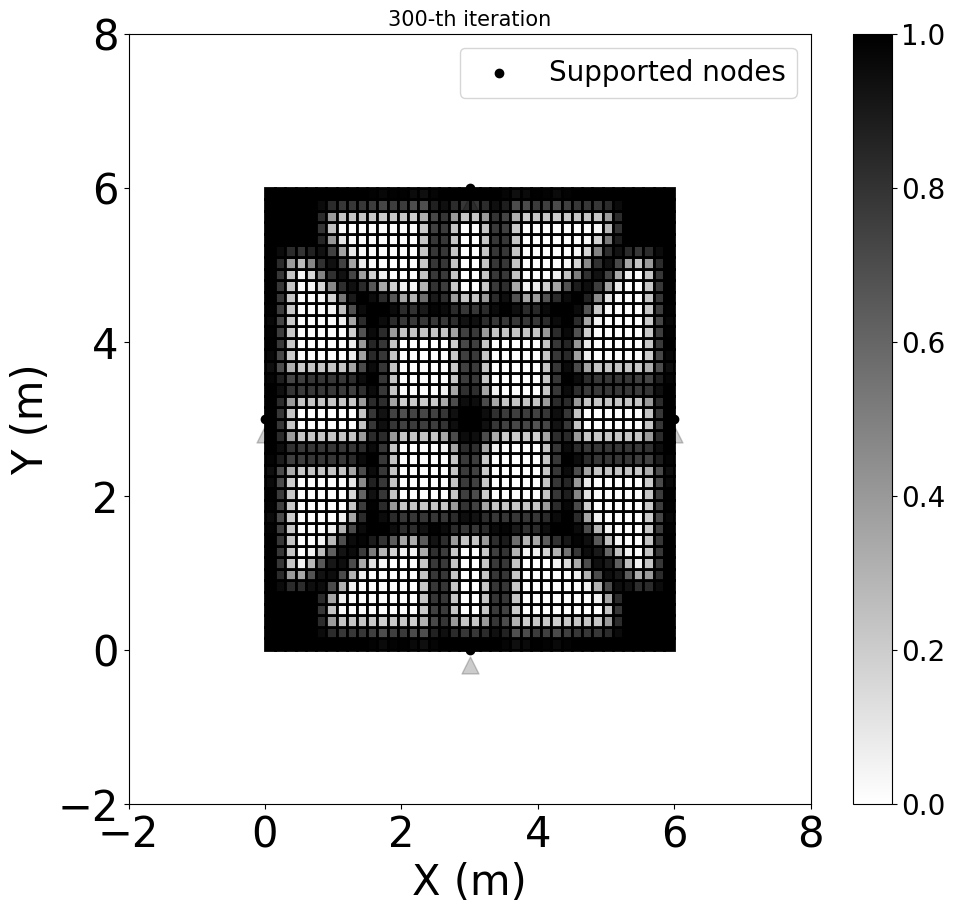

In [17]:

n_dim = sso_model.parameter_values.shape[0]
opt = nlopt.opt(nlopt.LD_MMA, n_dim)
opt.set_min_objective(f)
opt.set_lower_bounds(0.01*np.ones(n_dim)) # Lower bounds
opt.set_upper_bounds(np.ones(n_dim)) #Upper bounds
opt.set_maxeval(300)
opt.add_inequality_constraint(fc)

xopt = opt.optimize(x_ini)


    
    
    

Text(0, 0.5, 'Total strain energy (N$\\cdot$m)')

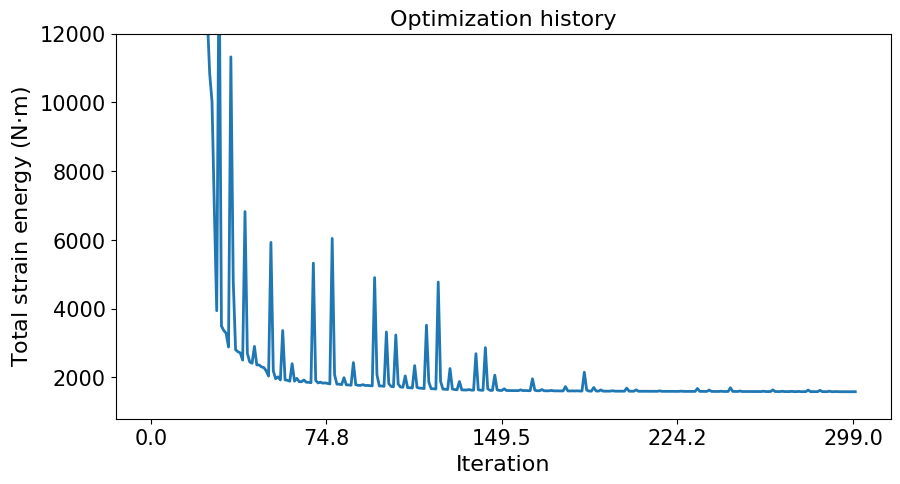

In [18]:

n_iter = np.array(C_hist).shape[0]
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(np.linspace(0,n_iter,n_iter),np.array(C_hist)*1000,linewidth=2)
plt.xticks(np.linspace(0,n_iter-1,5),fontsize=15)
plt.yticks(fontsize=15)
ax.set_ylim(800,12000)
plt.xlabel('Iteration',fontsize=16)
plt.title('Optimization history',fontsize=16)
plt.ylabel(r'Total strain energy (N$\cdot$m)',fontsize=16)

# Visualization

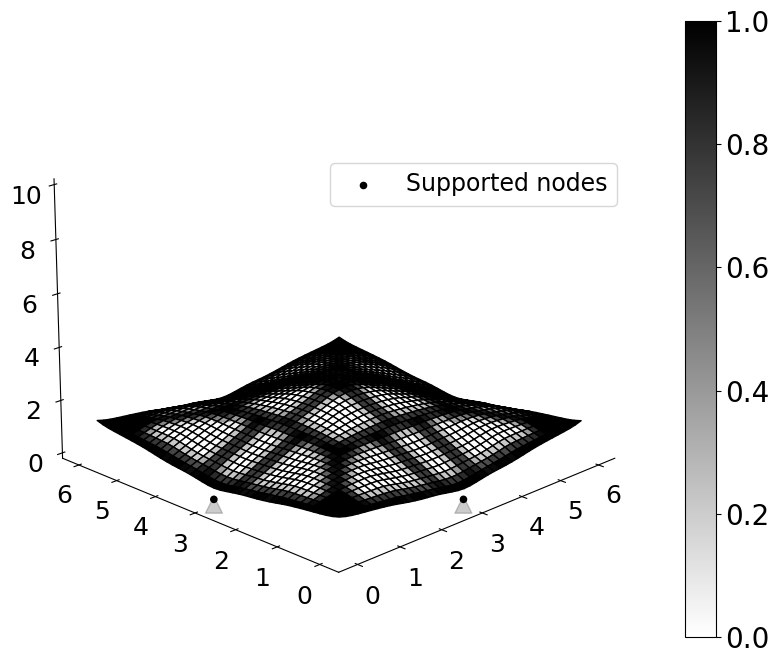

In [19]:
%matplotlib inline


mu_opt = xopt[sso_model.nodeparameters_values.shape[0]:]
zs[design_nodes] = og_p(xopt[:sso_model.nodeparameters_values.shape[0]])
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs)[design_nodes]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,10)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')


import matplotlib as mpl
cmap = mpl.colormaps['binary']
mu_opt_filtered = B_ij_shell@mu_opt
for i in range(n_ele):
    all_corners = []
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs_filtered[inode]],
                        [xs[jnode],ys[jnode],zs_filtered[jnode]],
                        [xs[mnode],ys[mnode],zs_filtered[mnode]],
                        [xs[nnode],ys[nnode],zs_filtered[nnode]],
                       ])
    
    tdco = Poly3DCollection(all_corners)
    alpha = float(mu_opt_filtered[i])
    tdco.set_facecolor(cmap(alpha))
    tdco.set_edgecolor('black')
    ax.add_collection3d(tdco)
    


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, -135)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

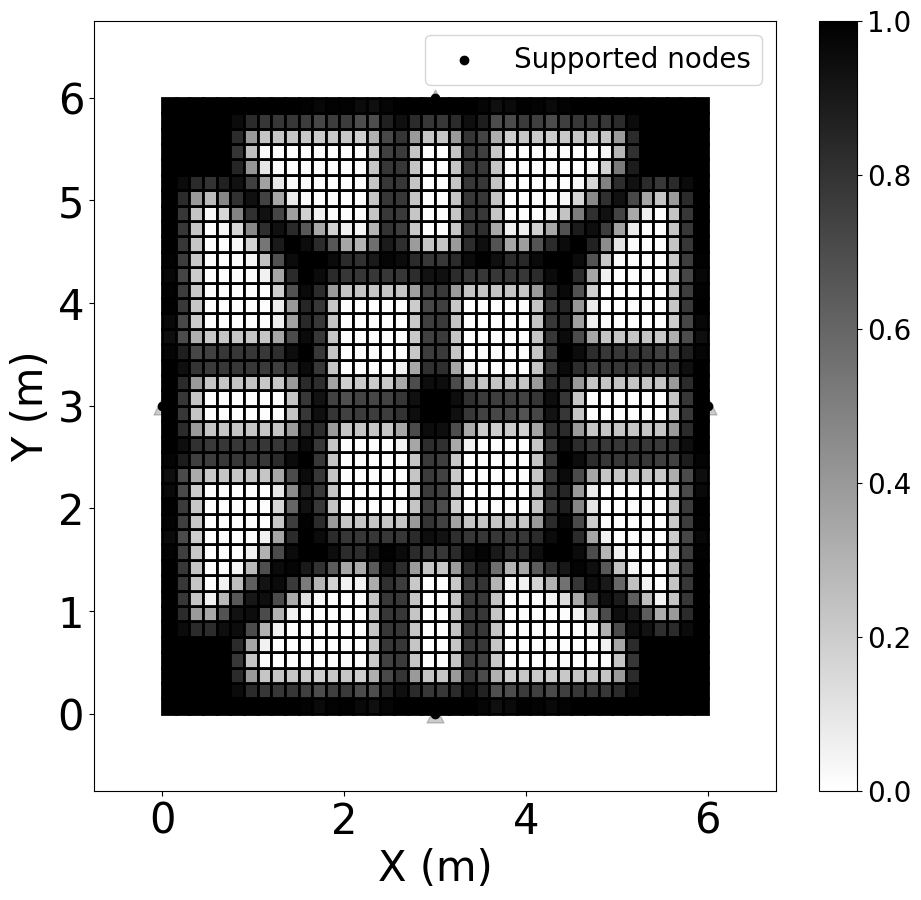

In [20]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-0.75,6.75)
ax.set_xlim(-0.75,6.75)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt_filtered[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()